<a href="https://colab.research.google.com/github/yashchauhan2910/Geoscience-with-Integrated-Data-Science---Heriot-Watt/blob/main/KMeans_Clustering_for_Well_Data_Yash_Singh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
created by **Farah Rabie** (f.rabie@hw.ac.uk)
***

#### Introduction

<p>In this notebook, we <b>explore how to apply KMeans clustering to well log data</b>. KMeans clustering is an unsupervised Machine Learning algorithm. The goal is to group similar sections of well log data, in efforts to uncover patterns or clusters that may correlate with different lithologies.

<p>As a reminder, we have well log data from 7 wells in the Volve field. In this notebook, we will work with the data in four steps:</p>
<ul>
    <li><b>Process</b> the data</b>: This includes addressing data anomalies and scaling the data.</li>
    <li><b>Apply</b> the KMeans algorithm to group the data into clusters.</li>
    This includes tuning <em>k</em>, a hyperparameter corresponding to the number of clusters.
    <li><b>Visualise</b> the clusters and compare them with true lithology.</li>
</ul>

We start with cloning the `GeosciencePlusAI` GitHub repository so we can access the data and modules needed for the notebook.

In [1]:
!rm -rf GeosciencePlusAI # If you're getting a fatal error here, try Runtime > Disconnect and delete runtime, then try Runtime > Run all
!git clone https://github.com/farah-rabie/GeosciencePlusAI.git

Cloning into 'GeosciencePlusAI'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 749 (delta 151), reused 107 (delta 107), pack-reused 578 (from 3)
Receiving objects: 100% (749/749), 131.72 MiB | 21.07 MiB/s, done.
Resolving deltas: 100% (425/425), done.
Updating files: 100% (53/53), done.


#### I$\,\,\,\,\,\,$Data Processing for Clustering

<p>We start off with processing the well log data. The <code>DataProcessing</code> class is imported from the <code>Lib.ClusteringFunctions</code> module and instantiated as <code>DataProcess.</code> This gives us access to functions for processing, scaling, and visualising well data.</p>

In [2]:
from GeosciencePlusAI.Lib.ClusteringFunctions import DataProcessing
DataProcess = DataProcessing()

<p>Using <code>process_well_data</code>, we can load well logs from multiple wells and process their data. This includes:
<ul>
    <li> Handling missing values - we will be removing them here.</li>
    <li> Applying a logarithmic transformation to KLOGH, the permeability log, and RT, the resistivity log.</li>
    <li> Limiting GR, the Gamma ray log, to values less than or equal to 150. </li>
</ul>

We start off with selecting our training wells, and storing them in `train_well_data_path`. We also need to identify which logs to process, and store them in `selected_columns_train`.

Make sure not to include the `LITHOLOGY` column in `selected_columns_train` - we are attempting to cluster the data with respect to its geophysical properties; the `LITHOLOGY` is the result you are trying to find.

In [ ]:
# List of wells:
#"/content/GeosciencePlusAI/Data/15_9-F-1 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-4.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-5.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-11 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-12.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-14.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"

In [ ]:
#train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv", "/content/GeosciencePlusAI/Data/15_9-F-14.csv", "/content/GeosciencePlusAI/Data/15_9-F-11 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-12.csv", "/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"]
#test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-4.csv" ,"/content/GeosciencePlusAI/Data/15_9-F-1 B.csv"]

In [3]:
train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv", "/content/GeosciencePlusAI/Data/15_9-F-14.csv", "/content/GeosciencePlusAI/Data/15_9-F-11 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-12.csv", "/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"]
selected_columns_train = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT'] # 'DT' and 'PEF' data were excluded

<p>In addition to cleaning the data, <code>process_well_data</code> also computes the scaling parameters. We scale the data to try and give all logs the same weight. Scaling parameters are computed on training data. To signal this as training data, <code>train_data</code> in <code>process_well_data</code> must be set to <code>True</code>. This prompts <code>process_well_data</code> to combine the data into a single DataFrame, and compute the scaling parameters for the different logs.

There are two different methods for scaling the data:
<ul>
  <li>setting `method` in <code>process_well_data</code> to `minmax_01` computes normalisation parameters</li>
  <li>setting method` in <code>process_well_data</code> to `standard` computes standardisation parameters.</li>
</ul>

The descriptive statistics and first few rows of the processed data can be displayed by setting <code>show_stats</code> and <code>show_rows</code> to <code>True,</code> respectively. This give us a snapshot of the cleaned data. </p>

In [5]:
processed_train_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_train, method = 'standard', train_data = True, show_stats = True, show_rows = True)


Descriptive Statistics of Data:
                BVW           VSH            GR          NPHI          RHOB  \
count  27199.000000  27199.000000  27199.000000  27199.000000  27199.000000   
mean       0.054441      0.304394     42.098988      0.190048      2.377644   
std        0.050347      0.195007     24.793518      0.055008      0.168620   
min        0.000000      0.000000      5.616400      0.000000      1.429500   
25%        0.026000      0.149900     23.316000      0.160000      2.229900   
50%        0.041000      0.271000     37.223000      0.185200      2.349000   
75%        0.071150      0.402300     53.609299      0.214000      2.518450   
max        1.000000      1.000000    149.294403      0.597300      3.090000   

          log_KLOGH        log_RT  
count  27199.000000  27199.000000  
mean       2.820566      2.728560  
std        2.678274      1.975984  
min        0.000000      0.107598  
25%        0.122262      1.212521  
50%        2.009649      2.177702  
75%

<p>When <code>train_data</code> is set to <code>False</code>, the data is considered testing data. In that case, <code>process_well_data</code> does not compute scaling parameters. It alse keeps the data for each well separate, in individual DataFrames. This is useful for independent testing.</p>

<p><b>❓Question</b></p>
<p>Notice how we include DEPTH and LITHOLOGY here. Why is that the case?</p>

In [6]:
selected_columns_test = ['DEPTH', 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded, 'DEPTH' and 'LITHOLOGY' have to be included here for visualisation

test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-4.csv" ,"/content/GeosciencePlusAI/Data/15_9-F-1 B.csv" ]
processed_test_well_data = DataProcess.process_well_data(test_well_data_path, selected_columns_test, train_data=False, show_stats=True, show_rows=False)


Descriptive Statistics of DataFrame 1:
             DEPTH          BVW          VSH           GR         NPHI  \
count  2367.000000  2367.000000  2367.000000  2367.000000  2367.000000   
mean   3314.101600     0.079131     0.344285    57.597573     0.216527   
std     104.550932     0.093713     0.230623    37.321649     0.078356   
min    3101.193802     0.002900     0.048900    10.681200     0.055700   
25%    3223.799847     0.035250     0.157500    27.726200     0.166700   
50%    3313.944628     0.068700     0.249200    42.127701     0.210300   
75%    3404.851410     0.107500     0.570950    92.646000     0.251150   
max    3494.996190     1.000000     0.799800   149.932693     0.732400   

              RHOB    log_KLOGH       log_RT  
count  2367.000000  2367.000000  2367.000000  
mean      2.370889     2.809140     2.017325  
std       0.178081     3.048482     1.282835  
min       1.334100     0.000300     0.392718  
25%       2.224100     0.001000     1.049772  
50%       2

<p> Next, we scale the data. The processed training well data is scaled using <code>scale_dataframe</code>. This scales the well logs based on previously computed scaling parameters. Setting <code>show_stats</code> to <code>True</code> displays descriptive statistics of the scaled data if the.</p>

In [7]:
standardised_train_well_data = DataProcess.scale_dataframe(processed_train_well_data, show_stats = True)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.054440651749365784, 'std': 0.05034711581731777}
VSH: {'mean': 0.3043938228708408, 'std': 0.19500727019808953}
GR: {'mean': 42.098988230541416, 'std': 24.793517740346747}
NPHI: {'mean': 0.19004813362483913, 'std': 0.055007652303676255}
RHOB: {'mean': 2.3776444721404832, 'std': 0.16861955000363169}
log_KLOGH: {'mean': 2.8205661159370417, 'std': 2.678273904078613}
log_RT: {'mean': 2.7285604369534706, 'std': 1.975983634768359}


<br>We must also scale the testing data.

In [8]:
standardised_test_well_data = [] #lets make an empty list for each dataframe under testing well

for df in processed_test_well_data:
  standardised_df = DataProcess.scale_dataframe(df, show_stats = True)
  standardised_test_well_data.append(standardised_df)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.054440651749365784, 'std': 0.05034711581731777}
VSH: {'mean': 0.3043938228708408, 'std': 0.19500727019808953}
GR: {'mean': 42.098988230541416, 'std': 24.793517740346747}
NPHI: {'mean': 0.19004813362483913, 'std': 0.055007652303676255}
RHOB: {'mean': 2.3776444721404832, 'std': 0.16861955000363169}
log_KLOGH: {'mean': 2.8205661159370417, 'std': 2.678273904078613}
log_RT: {'mean': 2.7285604369534706, 'std': 1.975983634768359}

Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.054440651749365784, 'std': 0.05034711581731777}
VSH: {'mean': 0.3043938228708408, 'std': 0.19500727019808953}
GR: {'mean': 42.098988230541416, 'std': 24.793517740346747}
NPHI: {'mean': 0.19004813362483913, 'std': 0.055007652303676255}
RHOB: {'mean': 2.3776444721404832, 'std': 0.16861955000363169}
log_KLOGH: {'mean': 2.8205661159370417, 'std': 2.678273904078613}
log_RT: {'mean': 2.7285604369534706, 'std': 1.975983634768359}


<br>
<p>And with that, data processing is complete.

We can visualise and compare distributions of any log before and after scaling using <code>compare_distributions</code>. This can help us to assess how scaling has transformed the log. We want to ensure the logs follow a consistent scale while retaining the overall shape and characteristics of the original distribution.

We select GR in this example. <code>compare_distributions</code> plots its distribution for both the processed data (<code>processed_train_well_data</code>) and the scaled data (<code>standardised_train_well_data</code>). </p>

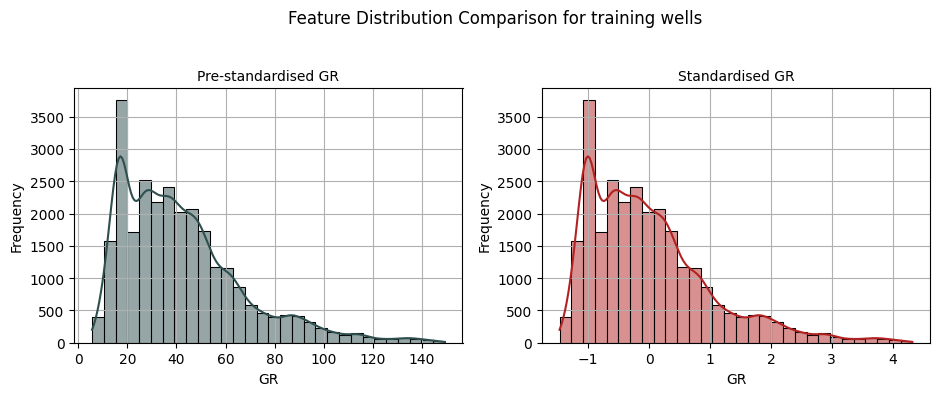

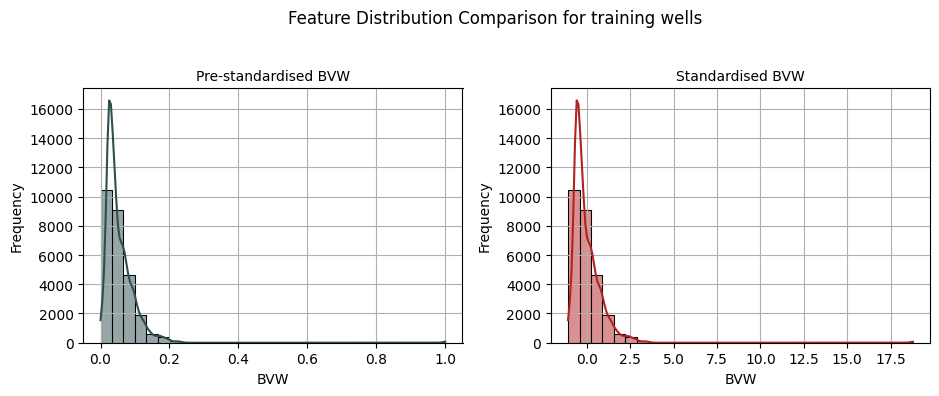

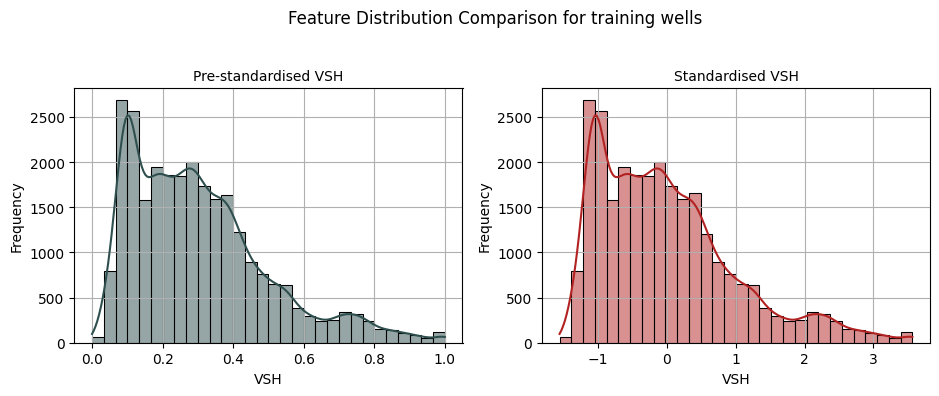

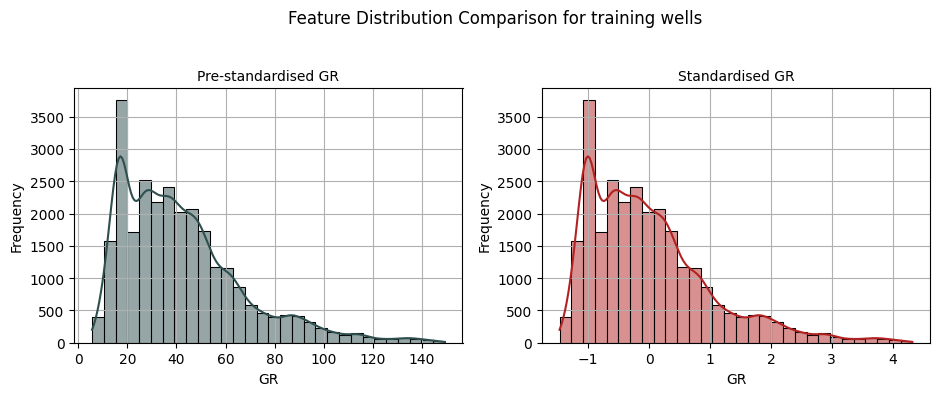

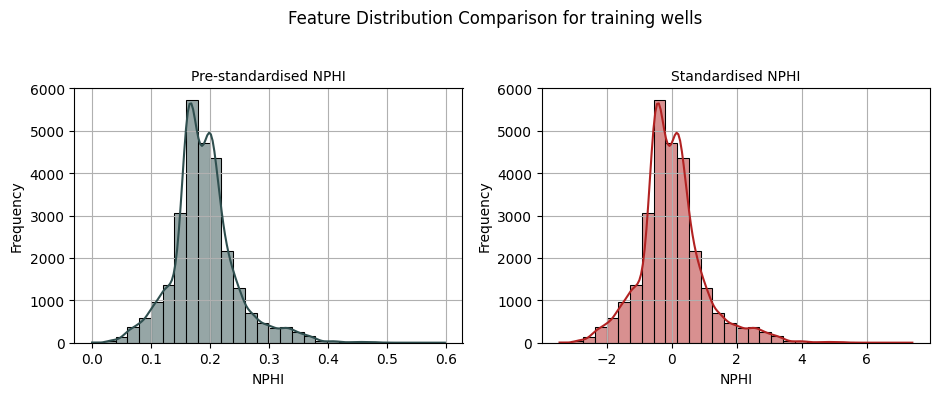

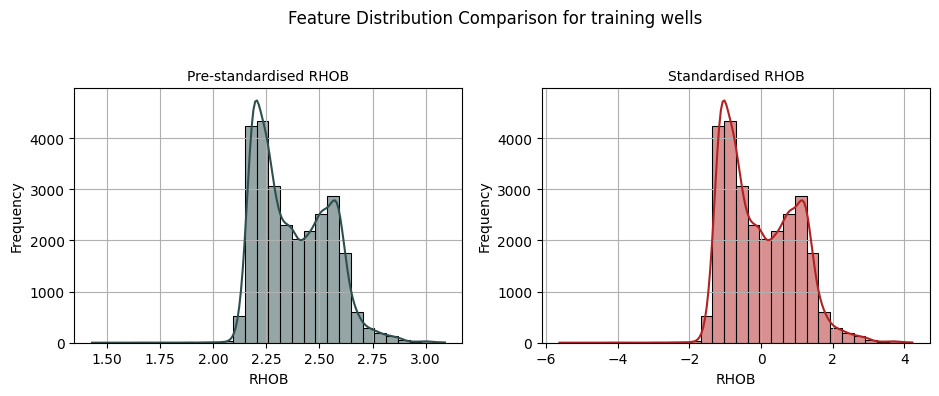

In [9]:
curves = ['GR','BVW', 'VSH', 'GR', 'NPHI', 'RHOB']

for curve in curves:
  DataProcess.compare_distributions(processed_train_well_data, standardised_train_well_data, curve, title="Feature Distribution Comparison for training wells")

#DataProcess.compare_distributions(processed_train_well_data, standardised_train_well_data, 'GR')
# Options: 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT'

#### II$\,\,\,\,\,\,$Choosing the Optimal Number of Clusters (Elbow Method)

<p>Next, we import the <code>KMeansClustering</code> class from the <code>ClusteringFunctions</code> module and create an instance of it, named <code>KMeans_Clustering</code>. This instance will be used to perform clustering tasks such as fitting the K-Means model, determining optimal cluster numbers, and analysing the results.</p>

In [15]:
from GeosciencePlusAI.Lib.ClusteringFunctions import KMeansClustering
KMeans_Clustering = KMeansClustering()

<p>The <code>KMeans_Clustering.elbow_method</code> is used to determine the optimal number of clusters for the standardised training dataset (<code>standardised_train_well_data</code>). By varying the number of clusters (<code>k</code>) from 1 to 10, it calculates and plots the <em>inertia</em>, the sum of squared distances to the nearest cluster centroid. The resulting <em>elbow</em> plot helps identify the ideal number of clusters, where the inertia starts to decrease more slowly, indicating a balance between underfitting and overfitting.</p>

k: 1
inertia:  190386.00000000114
k: 2
inertia:  123356.20477748827
k: 3
inertia:  101242.16362440874
k: 4
inertia:  88962.60758376576
k: 5
inertia:  76932.93183591017
k: 6
inertia:  66857.643840848
k: 7
inertia:  58737.64464034031
k: 8
inertia:  51249.040605249626
k: 9
inertia:  44279.10438577043
k: 10
inertia:  40529.7773763234


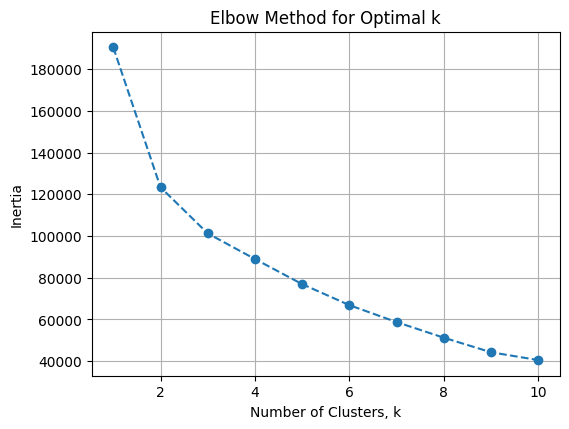

In [16]:
KMeans_Clustering.elbow_method(standardised_train_well_data, max_k = 10)

##### III$\,\,\,\,\,\,$Applying K-Means Clustering to Well Log Data

<p>Now that we have standardised our well log data, we can proceed with applying the KMeans clustering algorithm. We will begin by training the model using the standardised training dataset. For this exercise, we specify the number of clusters, <code>n_clusters = 5</code>, based on our previous analysis of the elbow chart.</p>

<p>The <show_stats=True> option will provide us with useful performance metrics, such as the <em>inertia</em> and <em>silhouette score</em>, which help us assess the quality of our clustering.</p>

In [17]:
train_clustered, kmeans_model = KMeans_Clustering.run_kmeans_train(standardised_train_well_data, n_clusters = 5, show_stats = True)

K-Means Clustering Results (Training Data) with 5 Clusters
Inertia (Sum of Squared Distances to Centroids): 76932.93183591017
Silhouette Score (Training Data): 0.2928


In [18]:
test_clustered_1, kmeans_model = KMeans_Clustering.run_kmeans_train(standardised_test_well_data[0], n_clusters = 5, show_stats = True)

K-Means Clustering Results (Training Data) with 5 Clusters
Inertia (Sum of Squared Distances to Centroids): 4554.869597548354
Silhouette Score (Training Data): 0.4610


In [19]:
test_clustered_2, kmeans_model = KMeans_Clustering.run_kmeans_train(standardised_test_well_data[1], n_clusters = 5, show_stats = True)

K-Means Clustering Results (Training Data) with 5 Clusters
Inertia (Sum of Squared Distances to Centroids): 1989.7521256010562
Silhouette Score (Training Data): 0.3844


We can now use the trained KMeans model to predict the clusters for the first well in our training dataset.

In [20]:
#train_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-4.csv","/content/GeosciencePlusAI/Data/15_9-F-1 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-11 B.csv", "/content/GeosciencePlusAI/Data/15_9-F-12.csv", "/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"]
#test_well_data_path = ["/content/GeosciencePlusAI/Data/15_9-F-5.csv", "/content/GeosciencePlusAI/Data/15_9-F-14.csv" ]

In [22]:
# train_well_data_path and selected_columns_test previously set
# train_data=False > even though this is training data, we want to process it as testing data so we can plot it

# for reference:
#standardised_train_singles_well_data
#"/content/GeosciencePlusAI/Data/15_9-F-4.csv" >> 0

#standardised_test_well_data
#"/content/GeosciencePlusAI/Data/15_9-F-5.csv" >> 0

standardised_train_singles_well_data = []
processed_train_singles_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_test, train_data = False, show_stats = False, show_rows = False)

for df in processed_train_singles_well_data:
  standardised_df = DataProcess.scale_dataframe(df, show_stats = True)
  standardised_train_singles_well_data.append(standardised_df)



Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.054440651749365784, 'std': 0.05034711581731777}
VSH: {'mean': 0.3043938228708408, 'std': 0.19500727019808953}
GR: {'mean': 42.098988230541416, 'std': 24.793517740346747}
NPHI: {'mean': 0.19004813362483913, 'std': 0.055007652303676255}
RHOB: {'mean': 2.3776444721404832, 'std': 0.16861955000363169}
log_KLOGH: {'mean': 2.8205661159370417, 'std': 2.678273904078613}
log_RT: {'mean': 2.7285604369534706, 'std': 1.975983634768359}

Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.054440651749365784, 'std': 0.05034711581731777}
VSH: {'mean': 0.3043938228708408, 'std': 0.19500727019808953}
GR: {'mean': 42.098988230541416, 'std': 24.793517740346747}
NPHI: {'mean': 0.19004813362483913, 'std': 0.055007652303676255}
RHOB: {'mean': 2.3776444721404832, 'std': 0.16861955000363169}
log_KLOGH: {'mean': 2.8205661159370417, 'std': 2.678273904078613}
log_RT: {'mean': 2.7285604369534706, 'std': 1.975983634768359}

Scaling Method: stand

In [23]:
standardised_train_singles_well_data

[            DEPTH       BVW       VSH        GR      NPHI      RHOB  \
 0     3248.869698 -0.485443 -0.376365 -0.305846 -1.140717  1.911733   
 1     3249.022098 -0.598657 -0.376365 -0.546897 -1.682459  1.971038   
 2     3249.174498 -0.602629 -0.376365 -0.787947 -2.226020  1.377986   
 3     3249.326899 -0.602629 -0.376365 -0.638594 -2.047863  1.377986   
 4     3249.479299 -0.600643 -0.376365 -0.787947 -1.869706  1.377986   
 ...           ...       ...       ...       ...       ...       ...   
 3391  3765.659131  0.281235  0.679493  0.531869 -0.893478  0.901767   
 3392  3765.811532  0.638753  0.870768  0.703079 -0.558979  0.720887   
 3393  3765.963932  1.343858  0.854872  0.688862 -0.535346  0.551867   
 3394  3766.116332  1.075719  0.667186  0.520483 -0.159035  0.489003   
 3395  3766.268733  1.848355  0.578472  0.438615 -0.369915  0.309902   
 
       LITHOLOGY  log_KLOGH    log_RT  
 0          Marl  -1.052755 -0.772673  
 1          Marl  -1.052755 -0.669951  
 2          Ma

In [24]:


train_clustered_1 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[0], kmeans_model)
train_clustered_2 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[1], kmeans_model)
train_clustered_3 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[2], kmeans_model)
train_clustered_4 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[3], kmeans_model)
train_clustered_5 = KMeans_Clustering.run_kmeans_test(standardised_train_singles_well_data[4], kmeans_model)


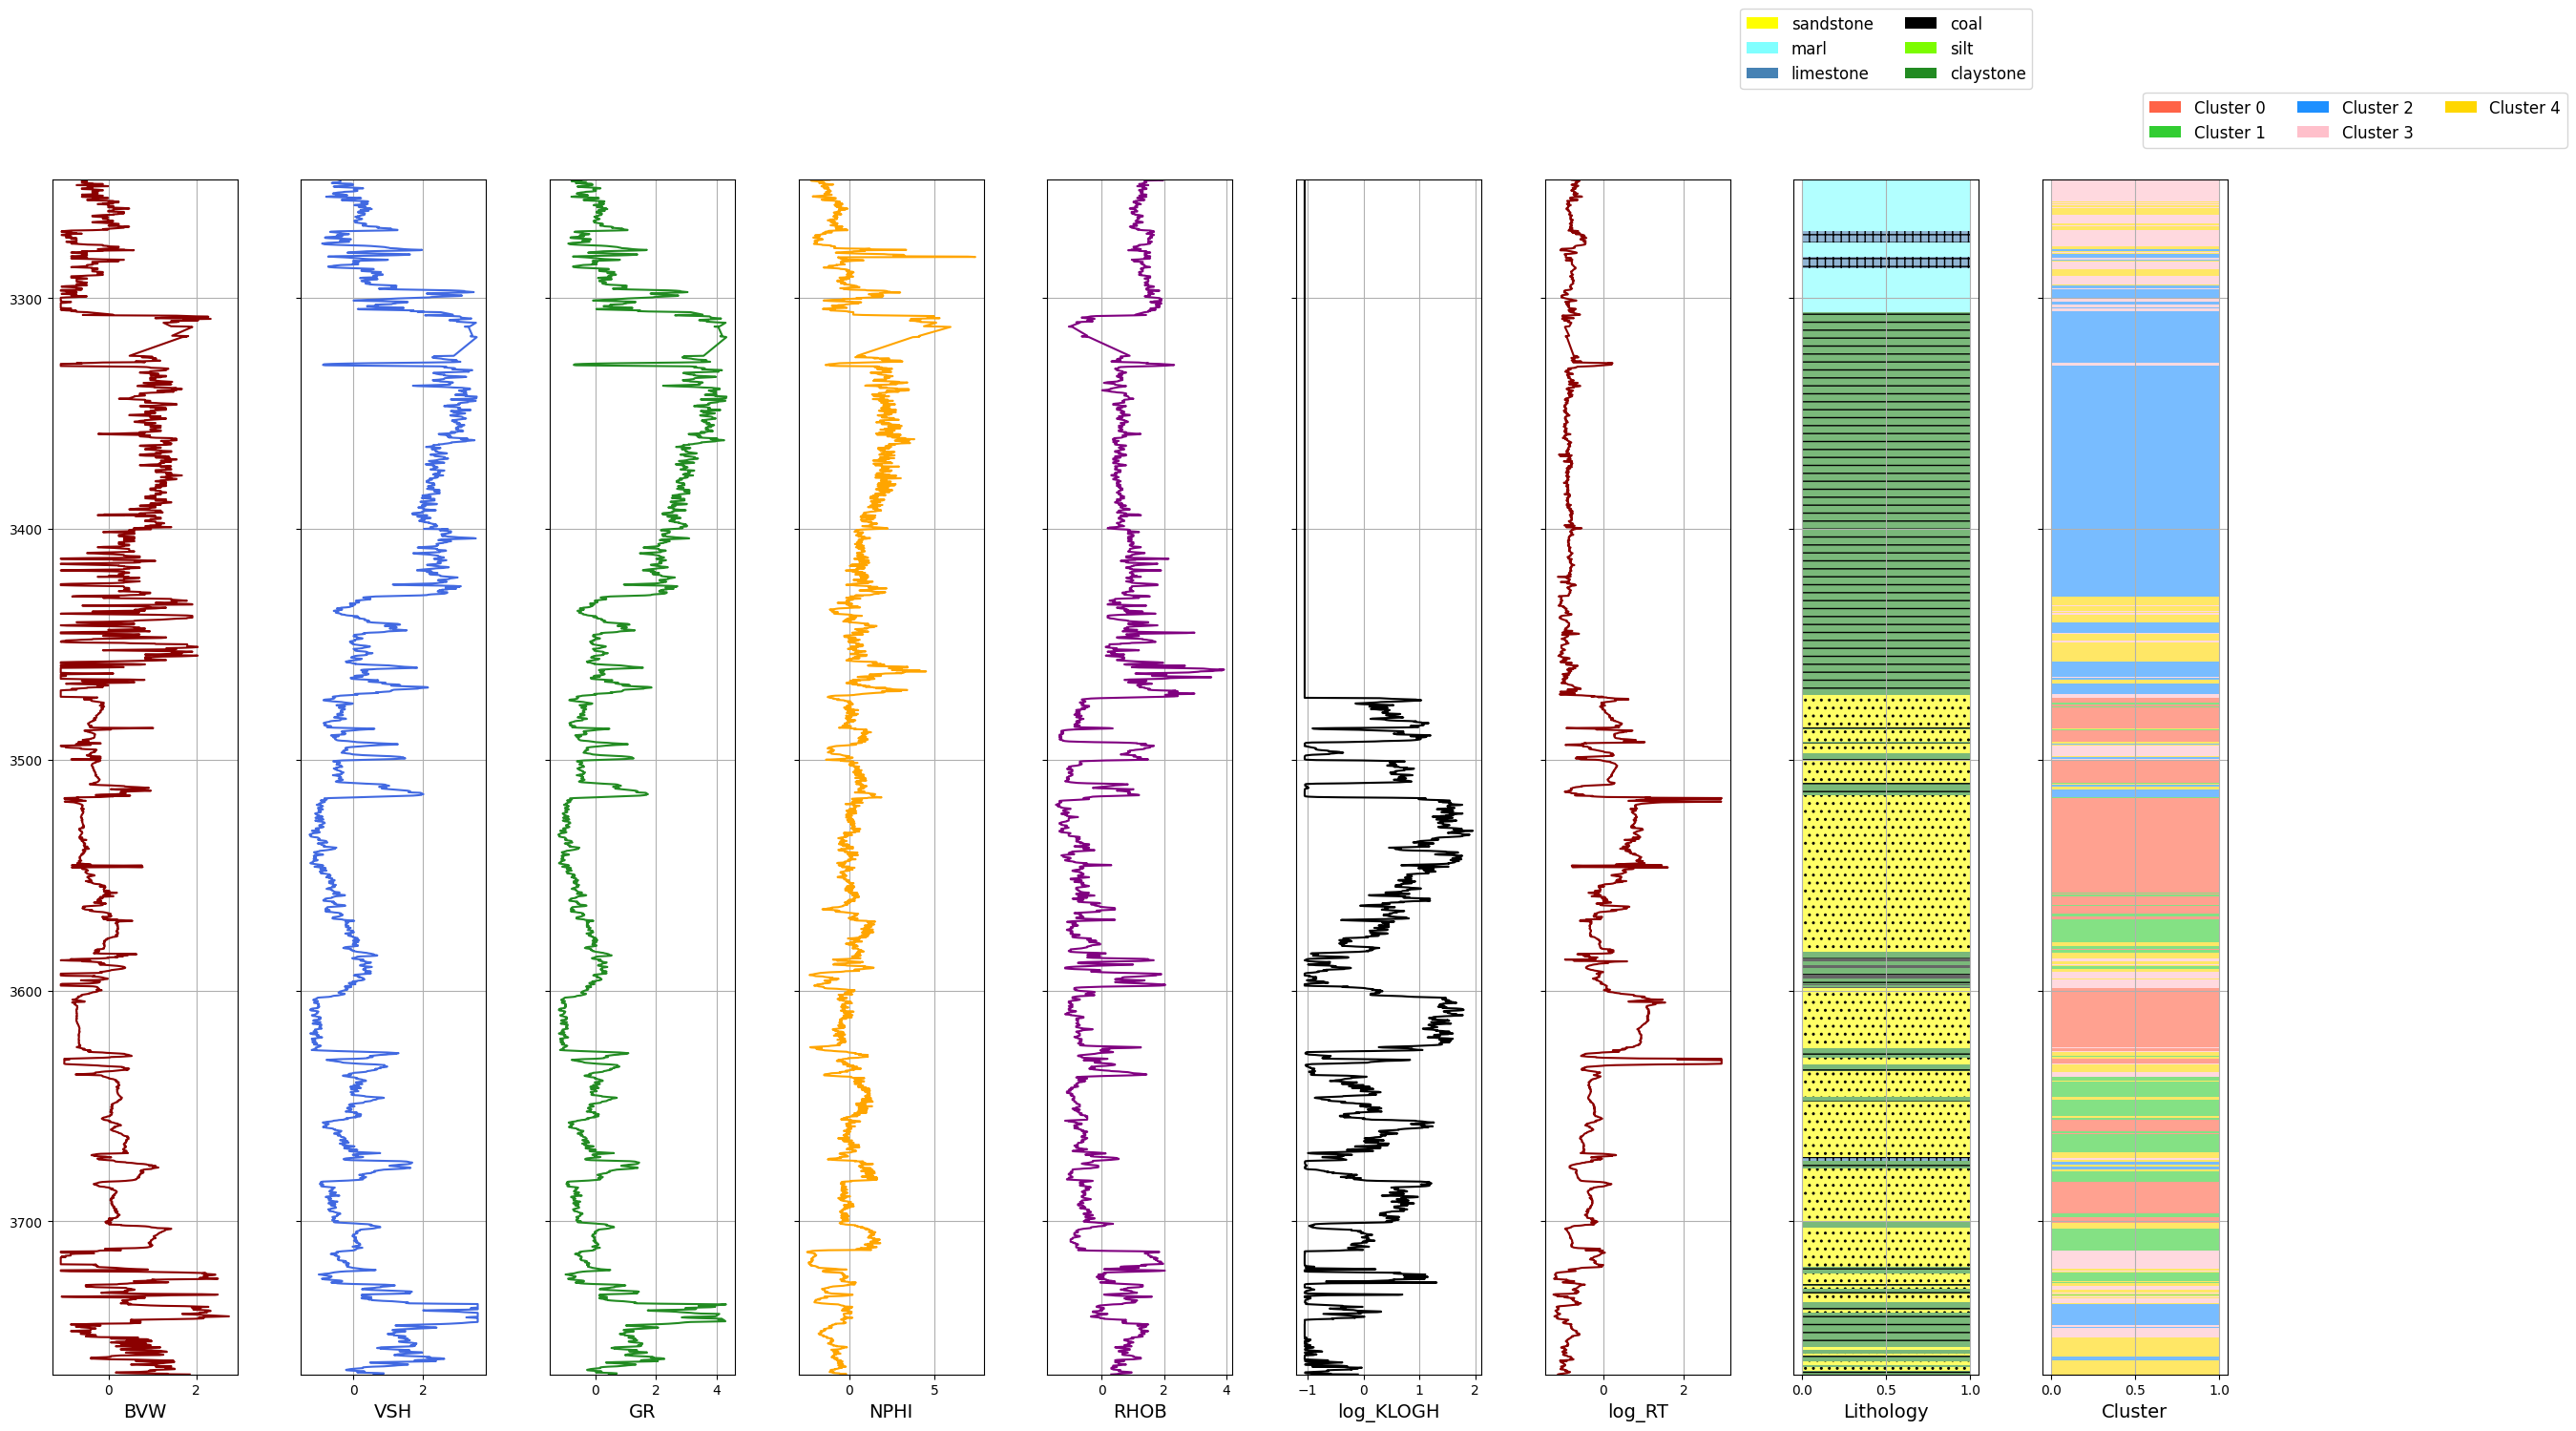

In [25]:

column_names = train_clustered_1.columns.tolist()
column_names = [col for col in column_names if col != "DEPTH"]
column_names = [col for col in column_names if col != "Cluster"]
column_names = [col for col in column_names if col != "LITHOLOGY"]

KMeans_Clustering.visualise_lithology_clusters(train_clustered_1, log_columns=column_names)

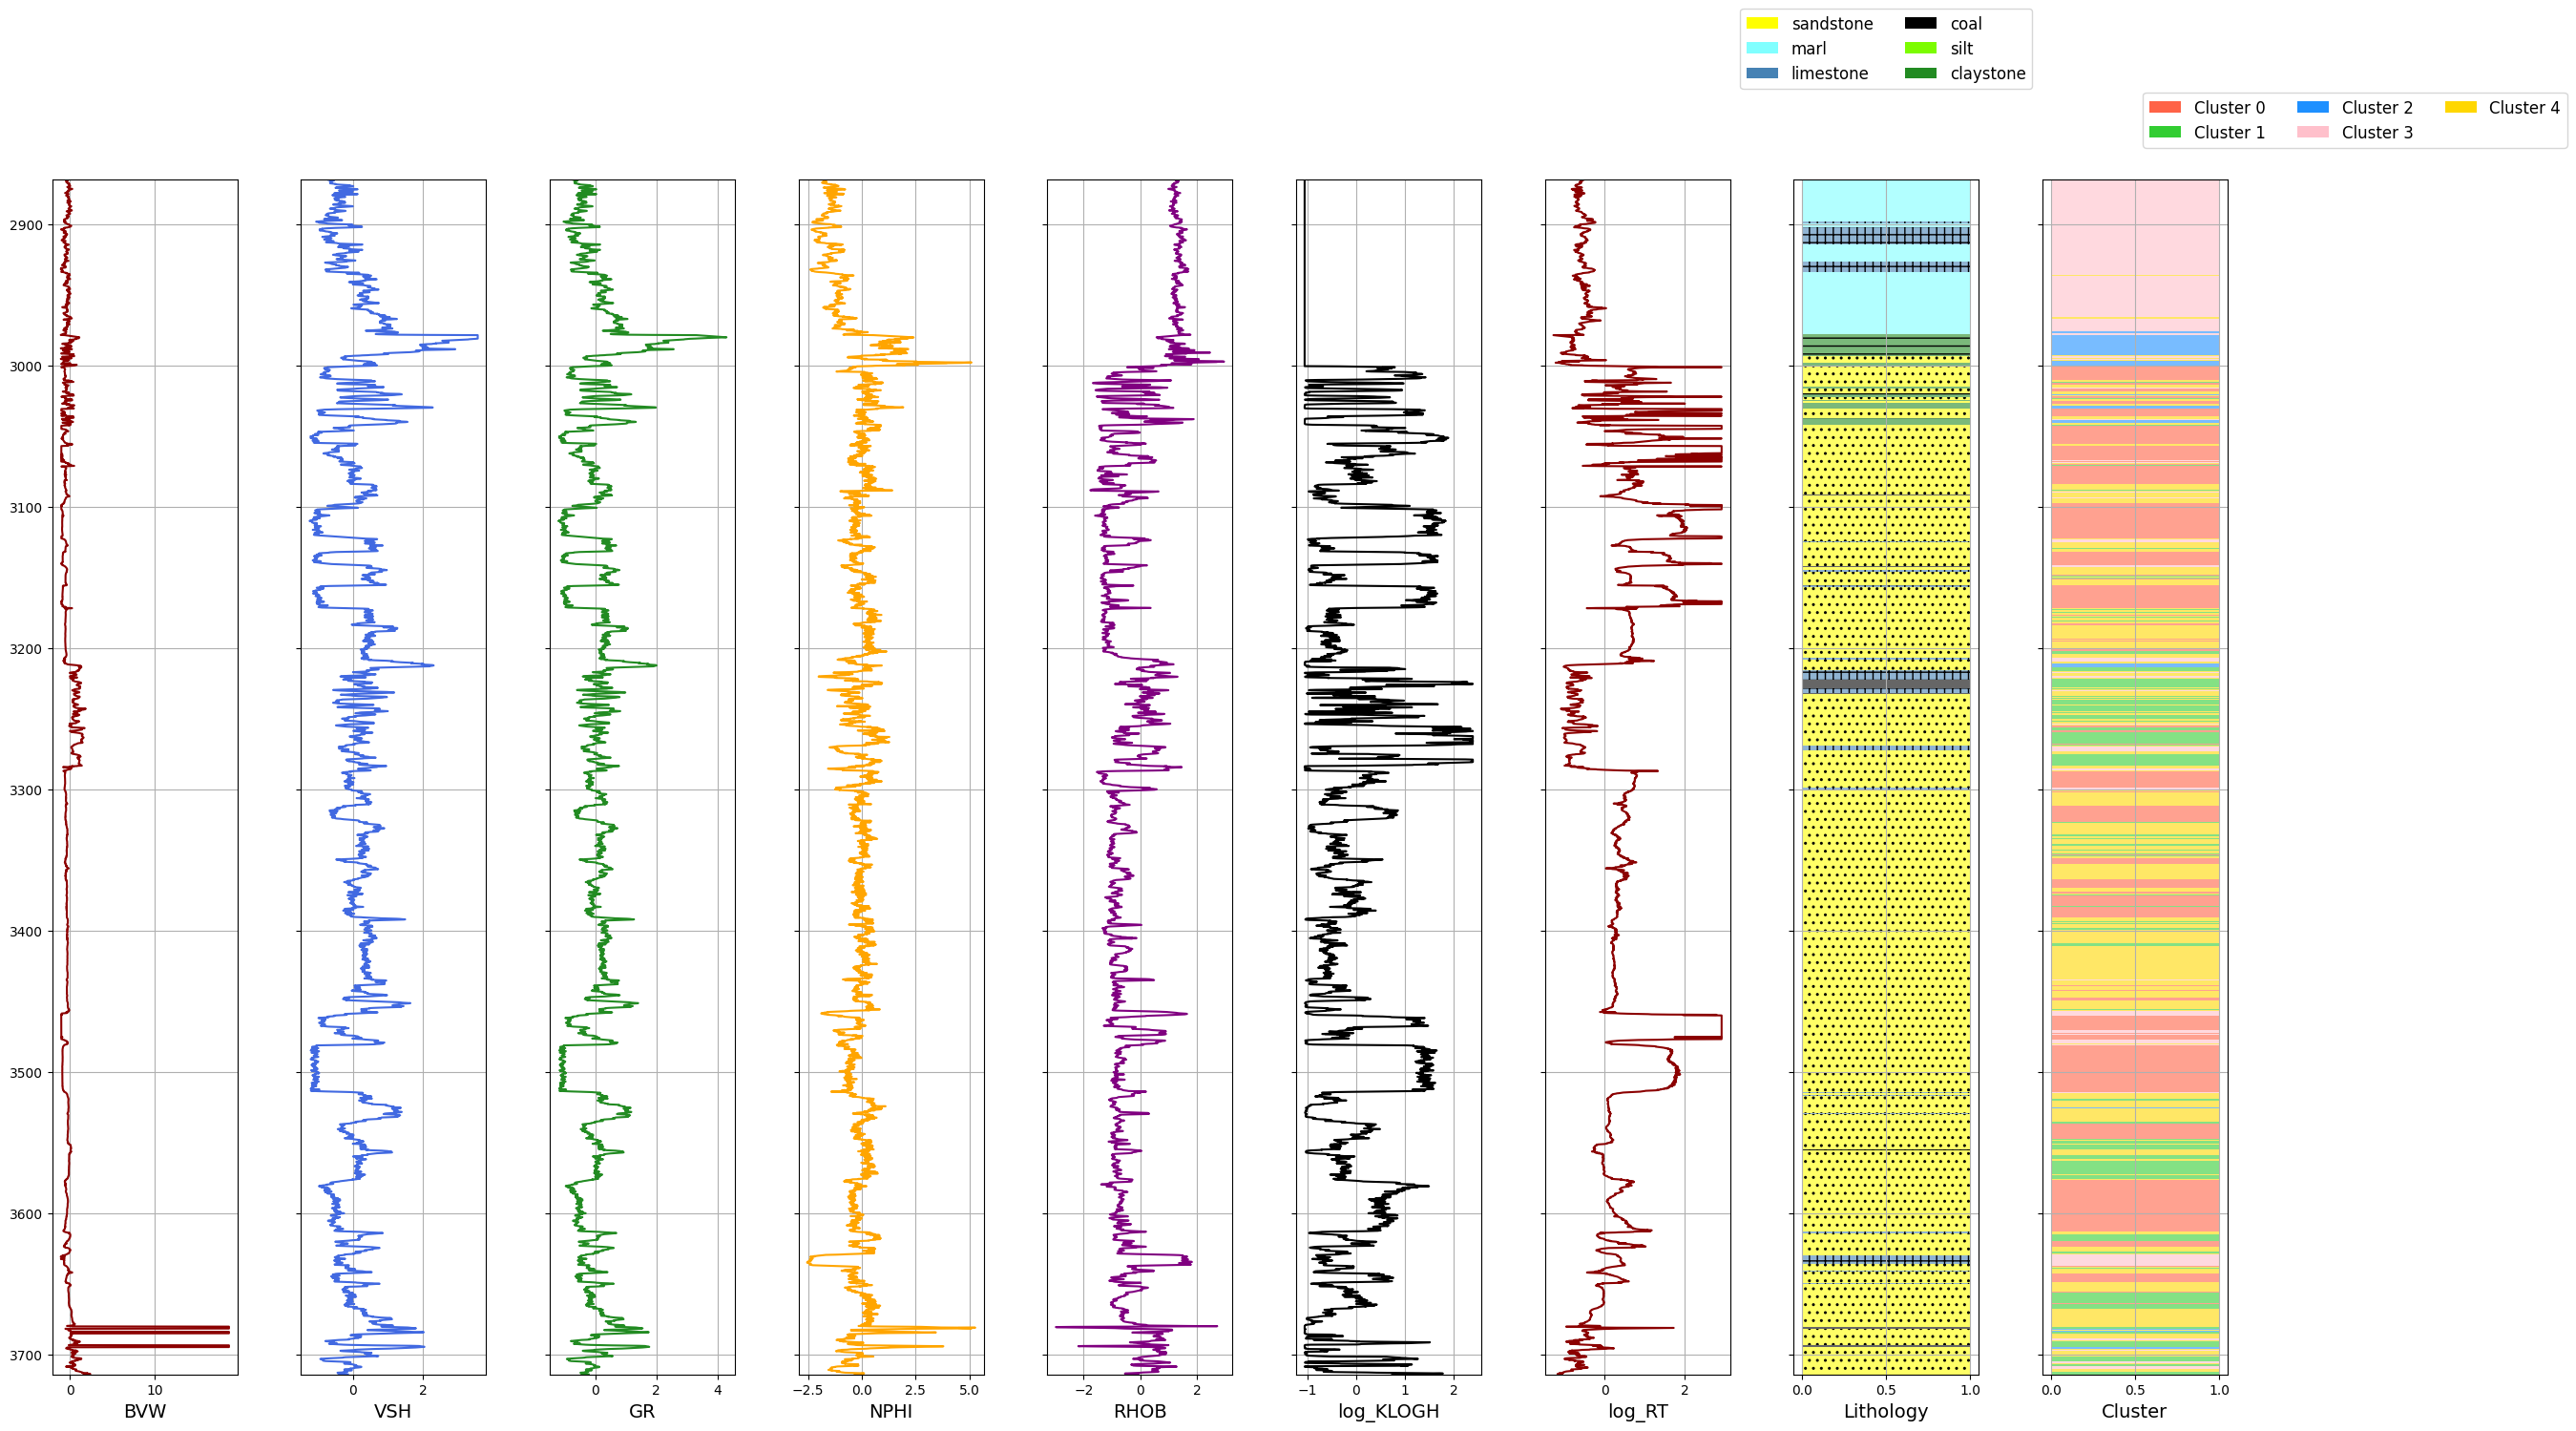

In [26]:
KMeans_Clustering.visualise_lithology_clusters(train_clustered_2, log_columns=column_names)

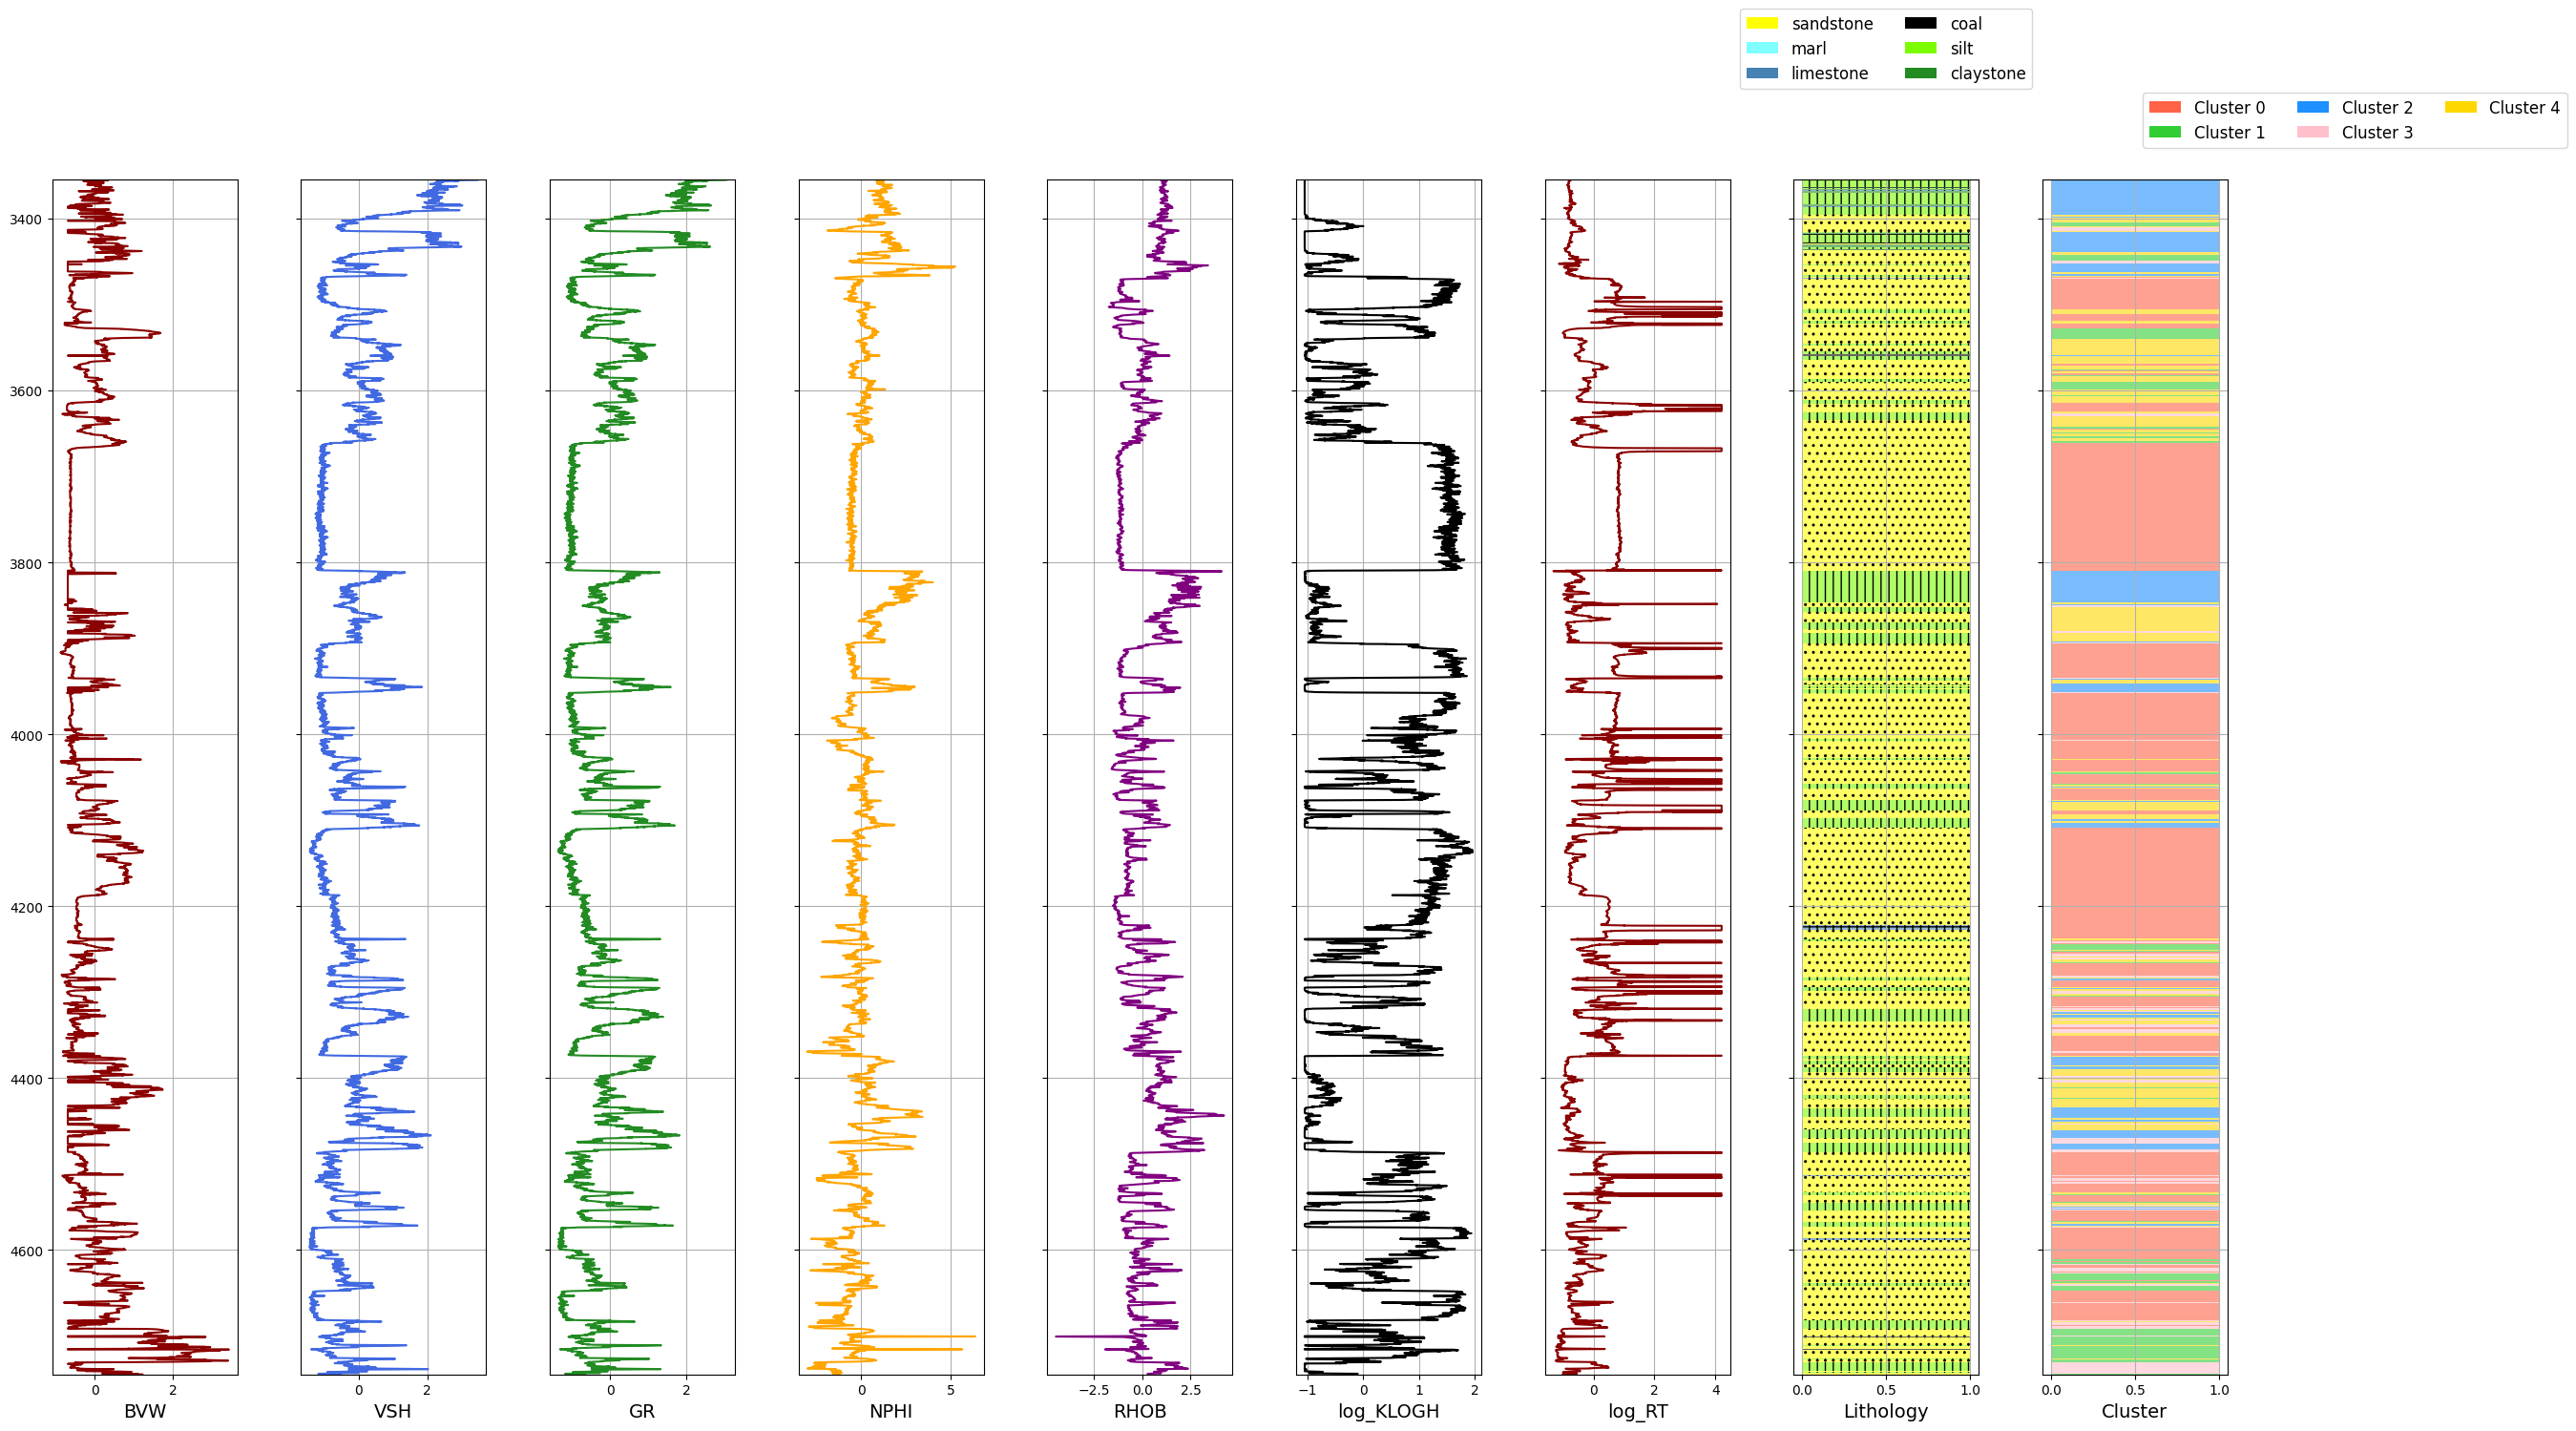

In [27]:
KMeans_Clustering.visualise_lithology_clusters(train_clustered_3, log_columns=column_names)

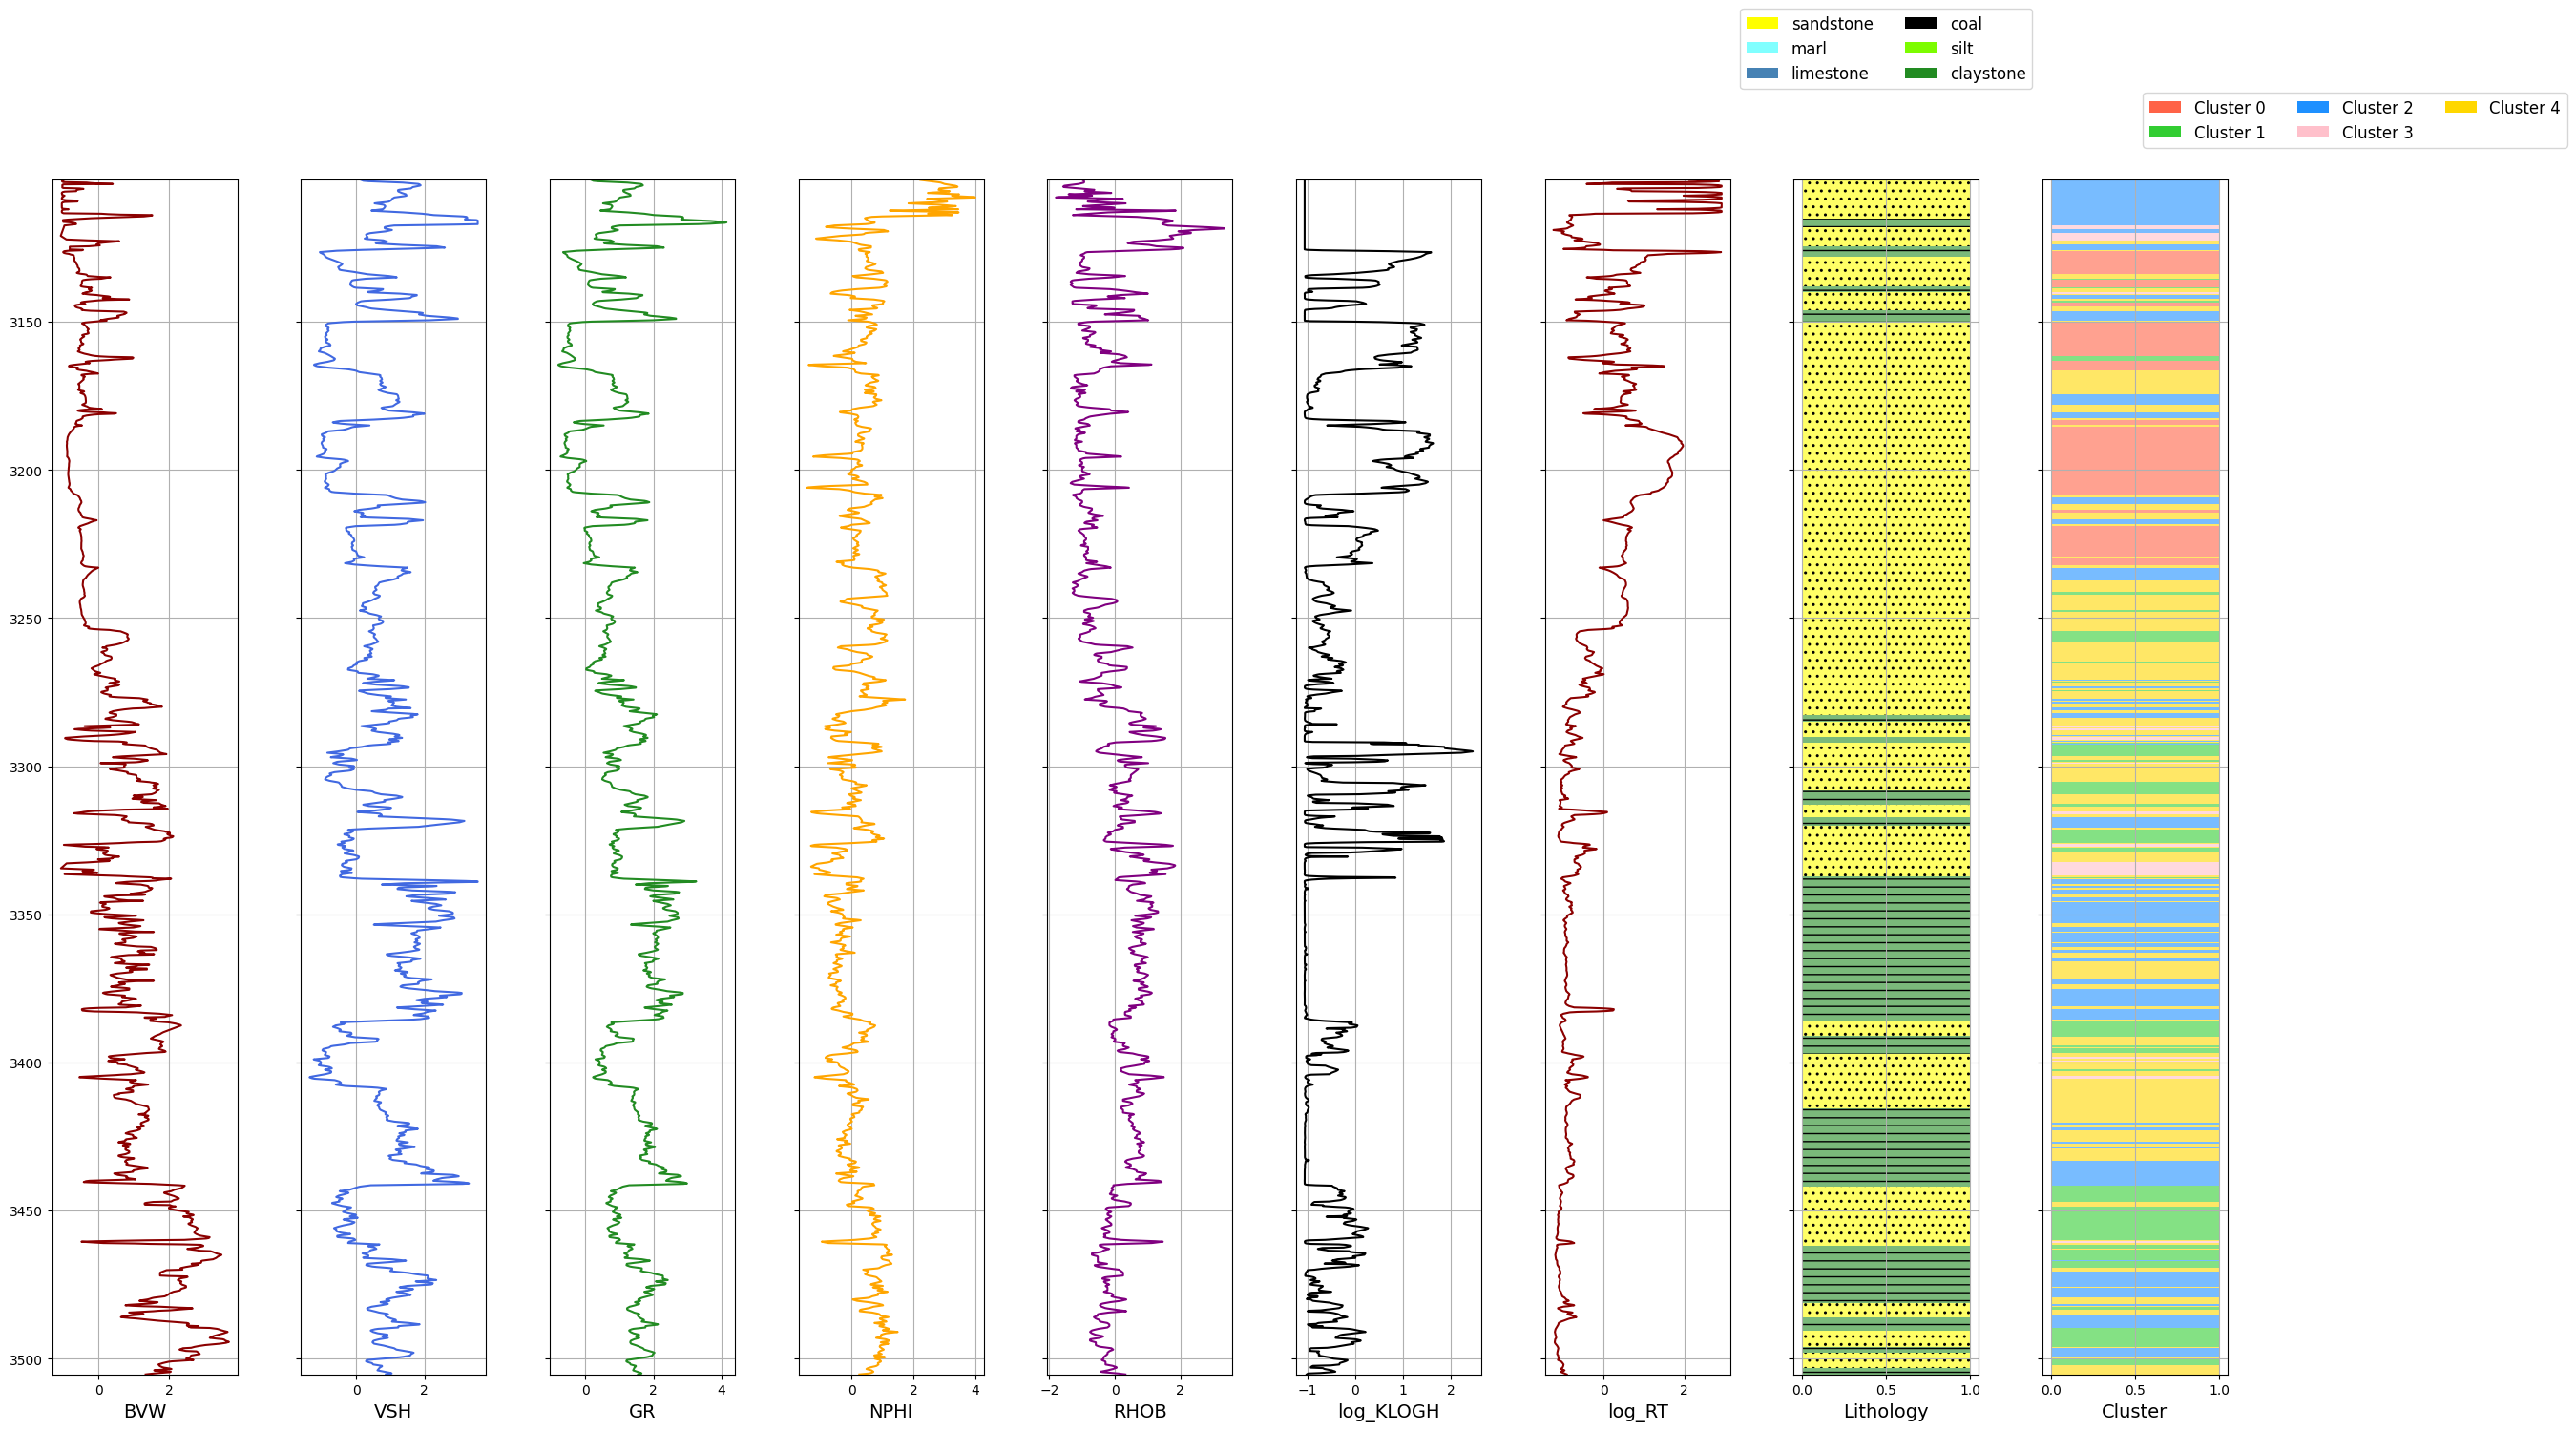

In [28]:
KMeans_Clustering.visualise_lithology_clusters(train_clustered_4, log_columns=column_names)

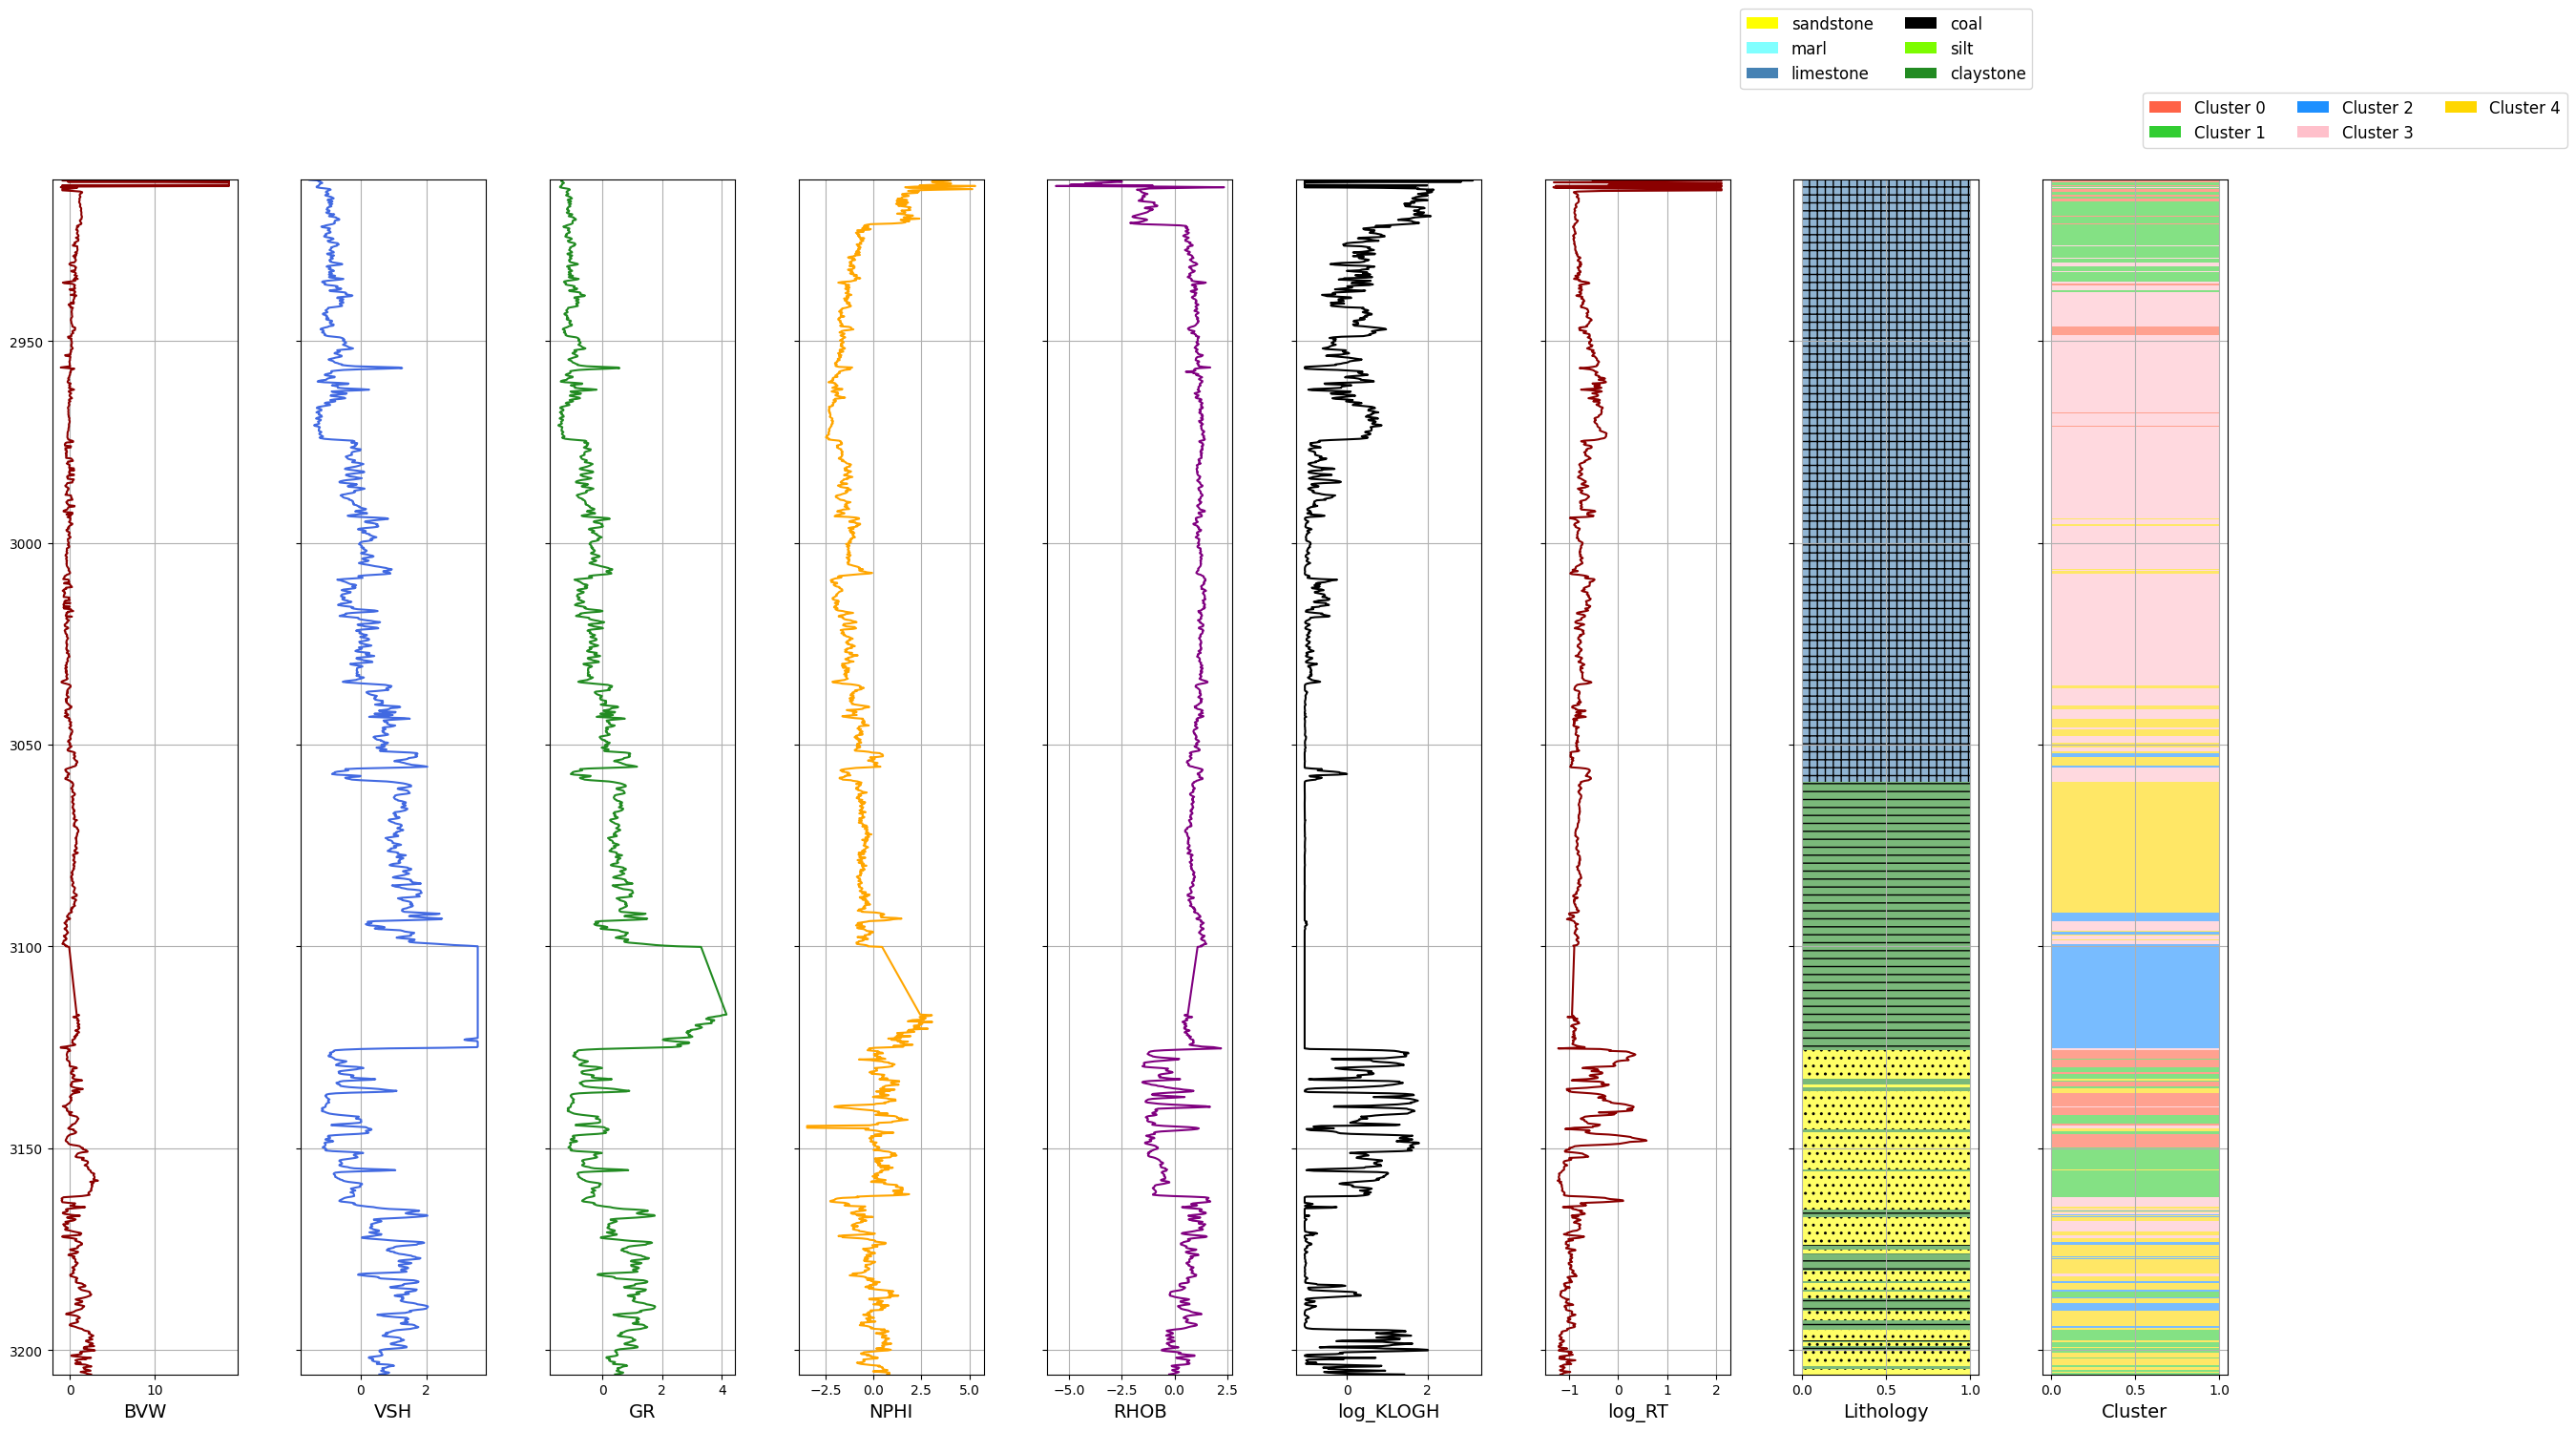

In [29]:

KMeans_Clustering.visualise_lithology_clusters(train_clustered_5, log_columns=column_names)

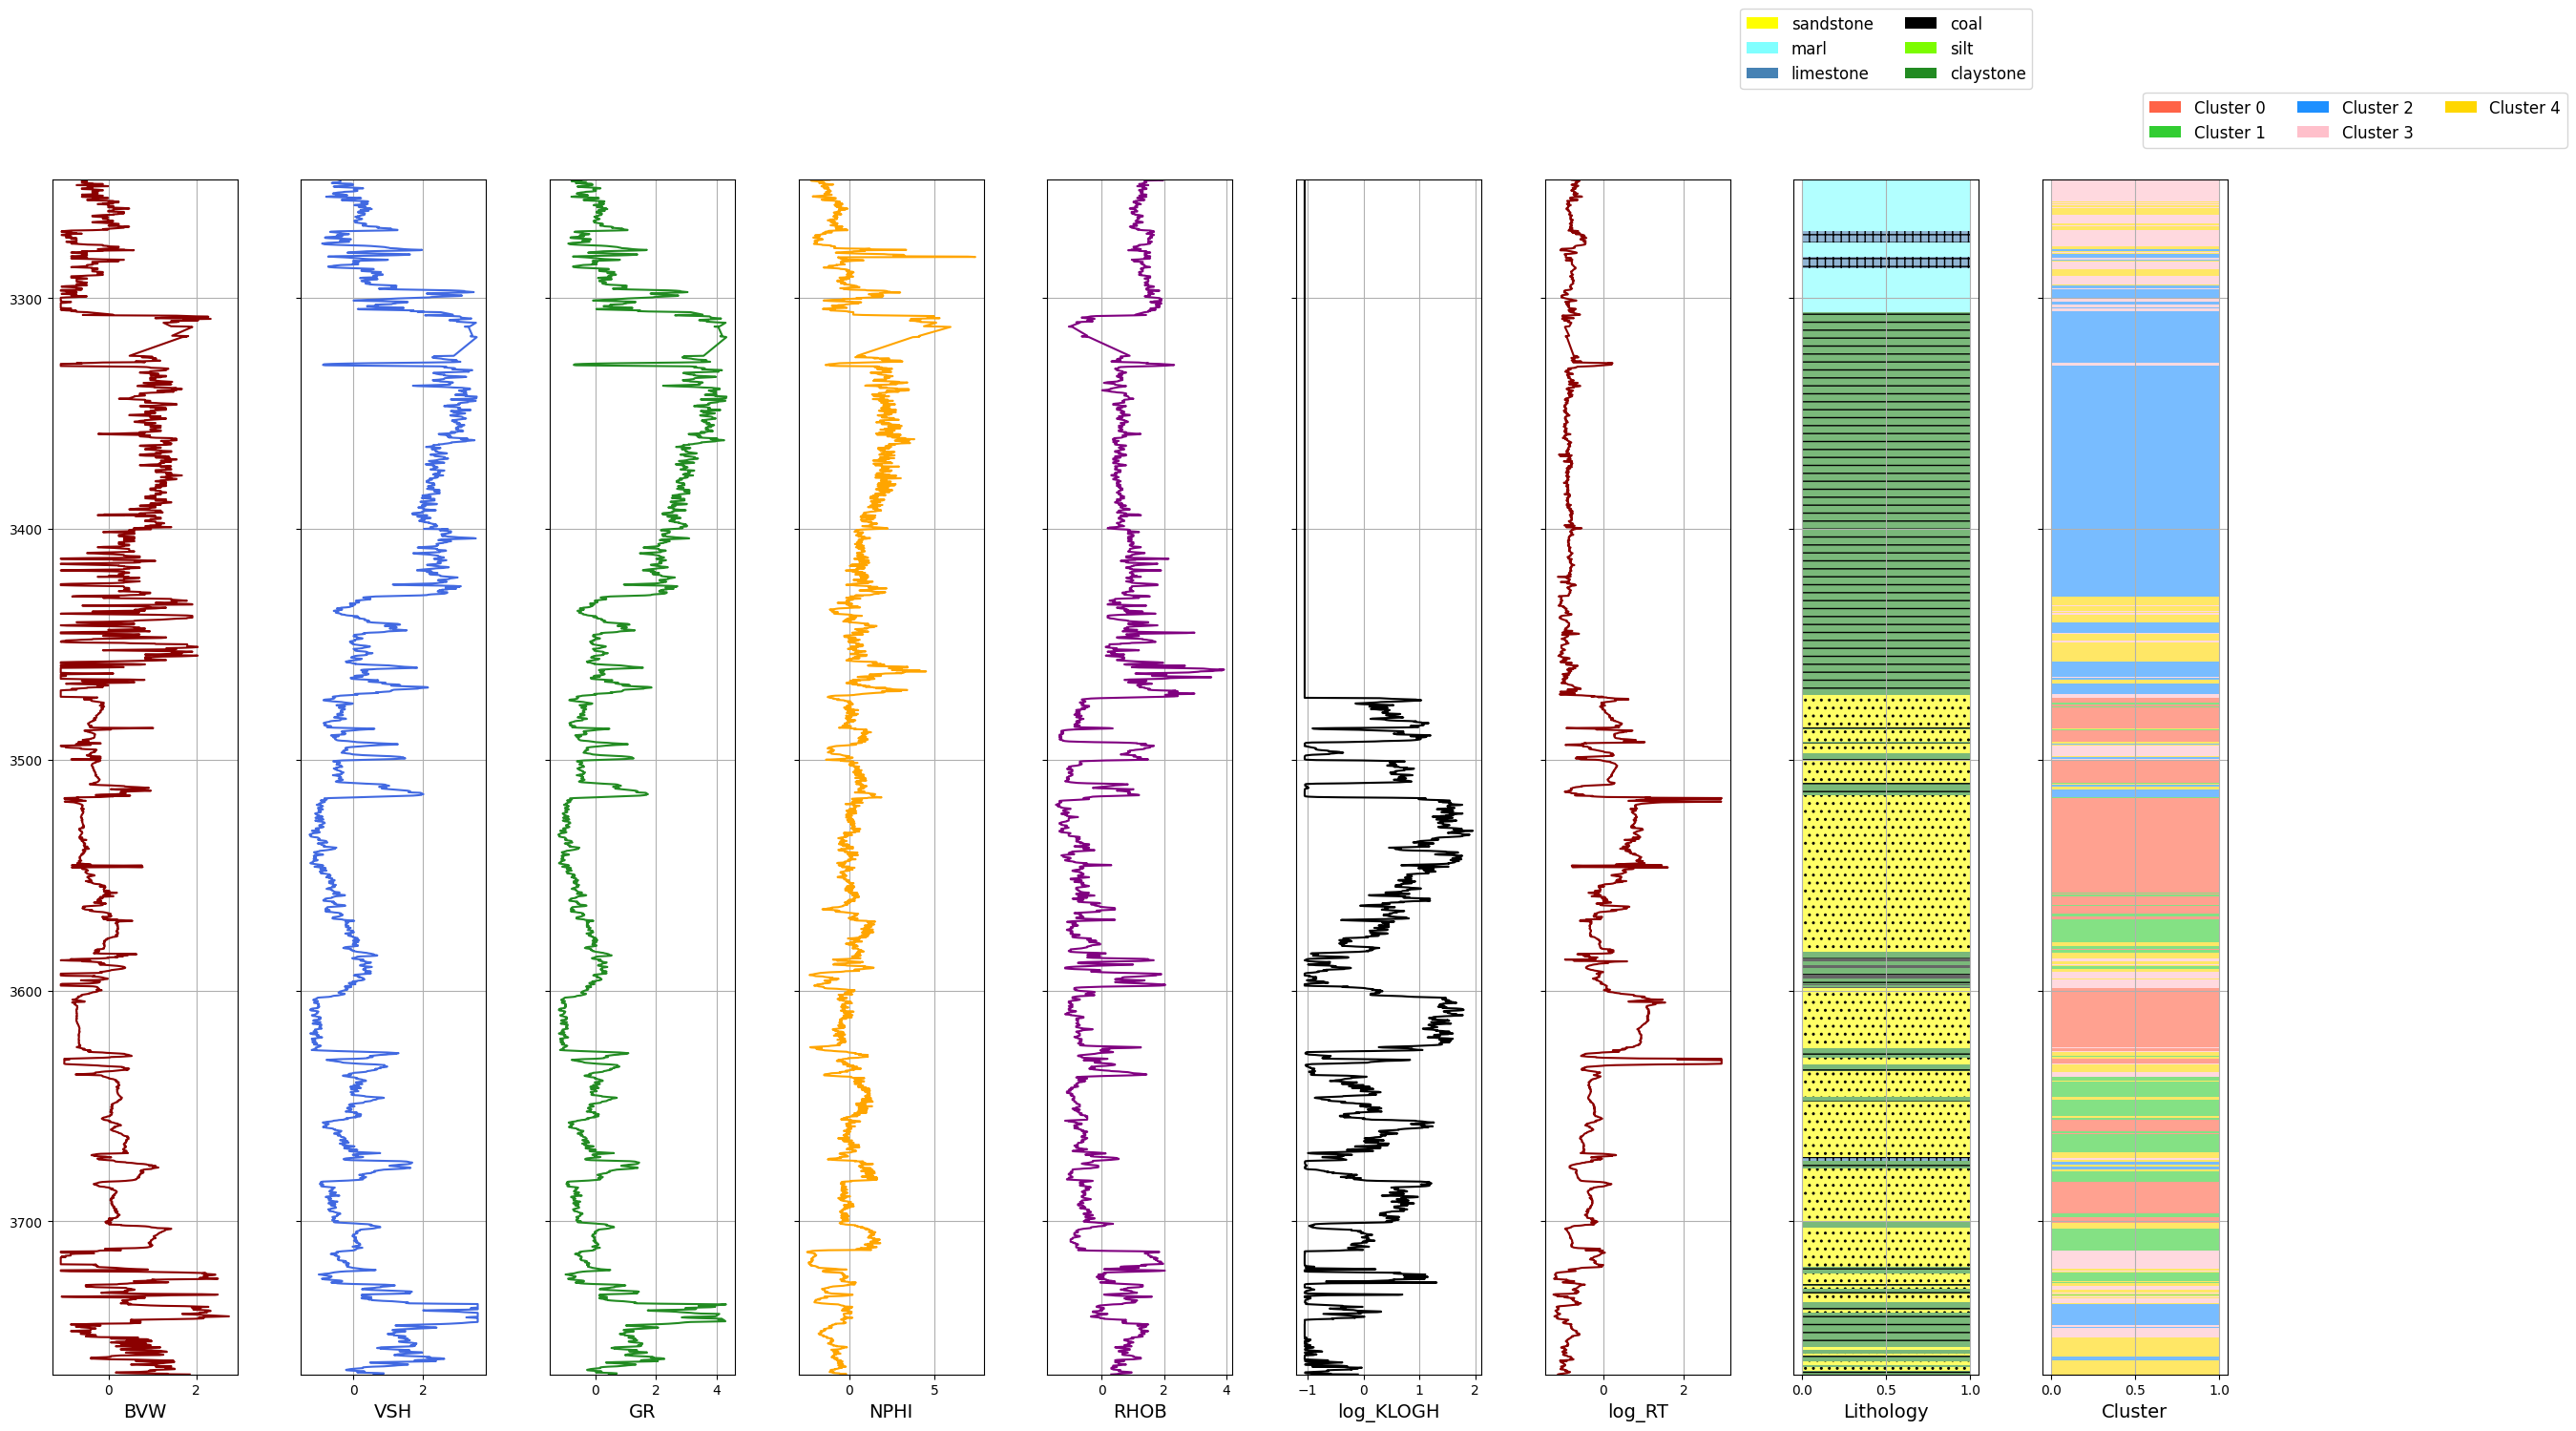

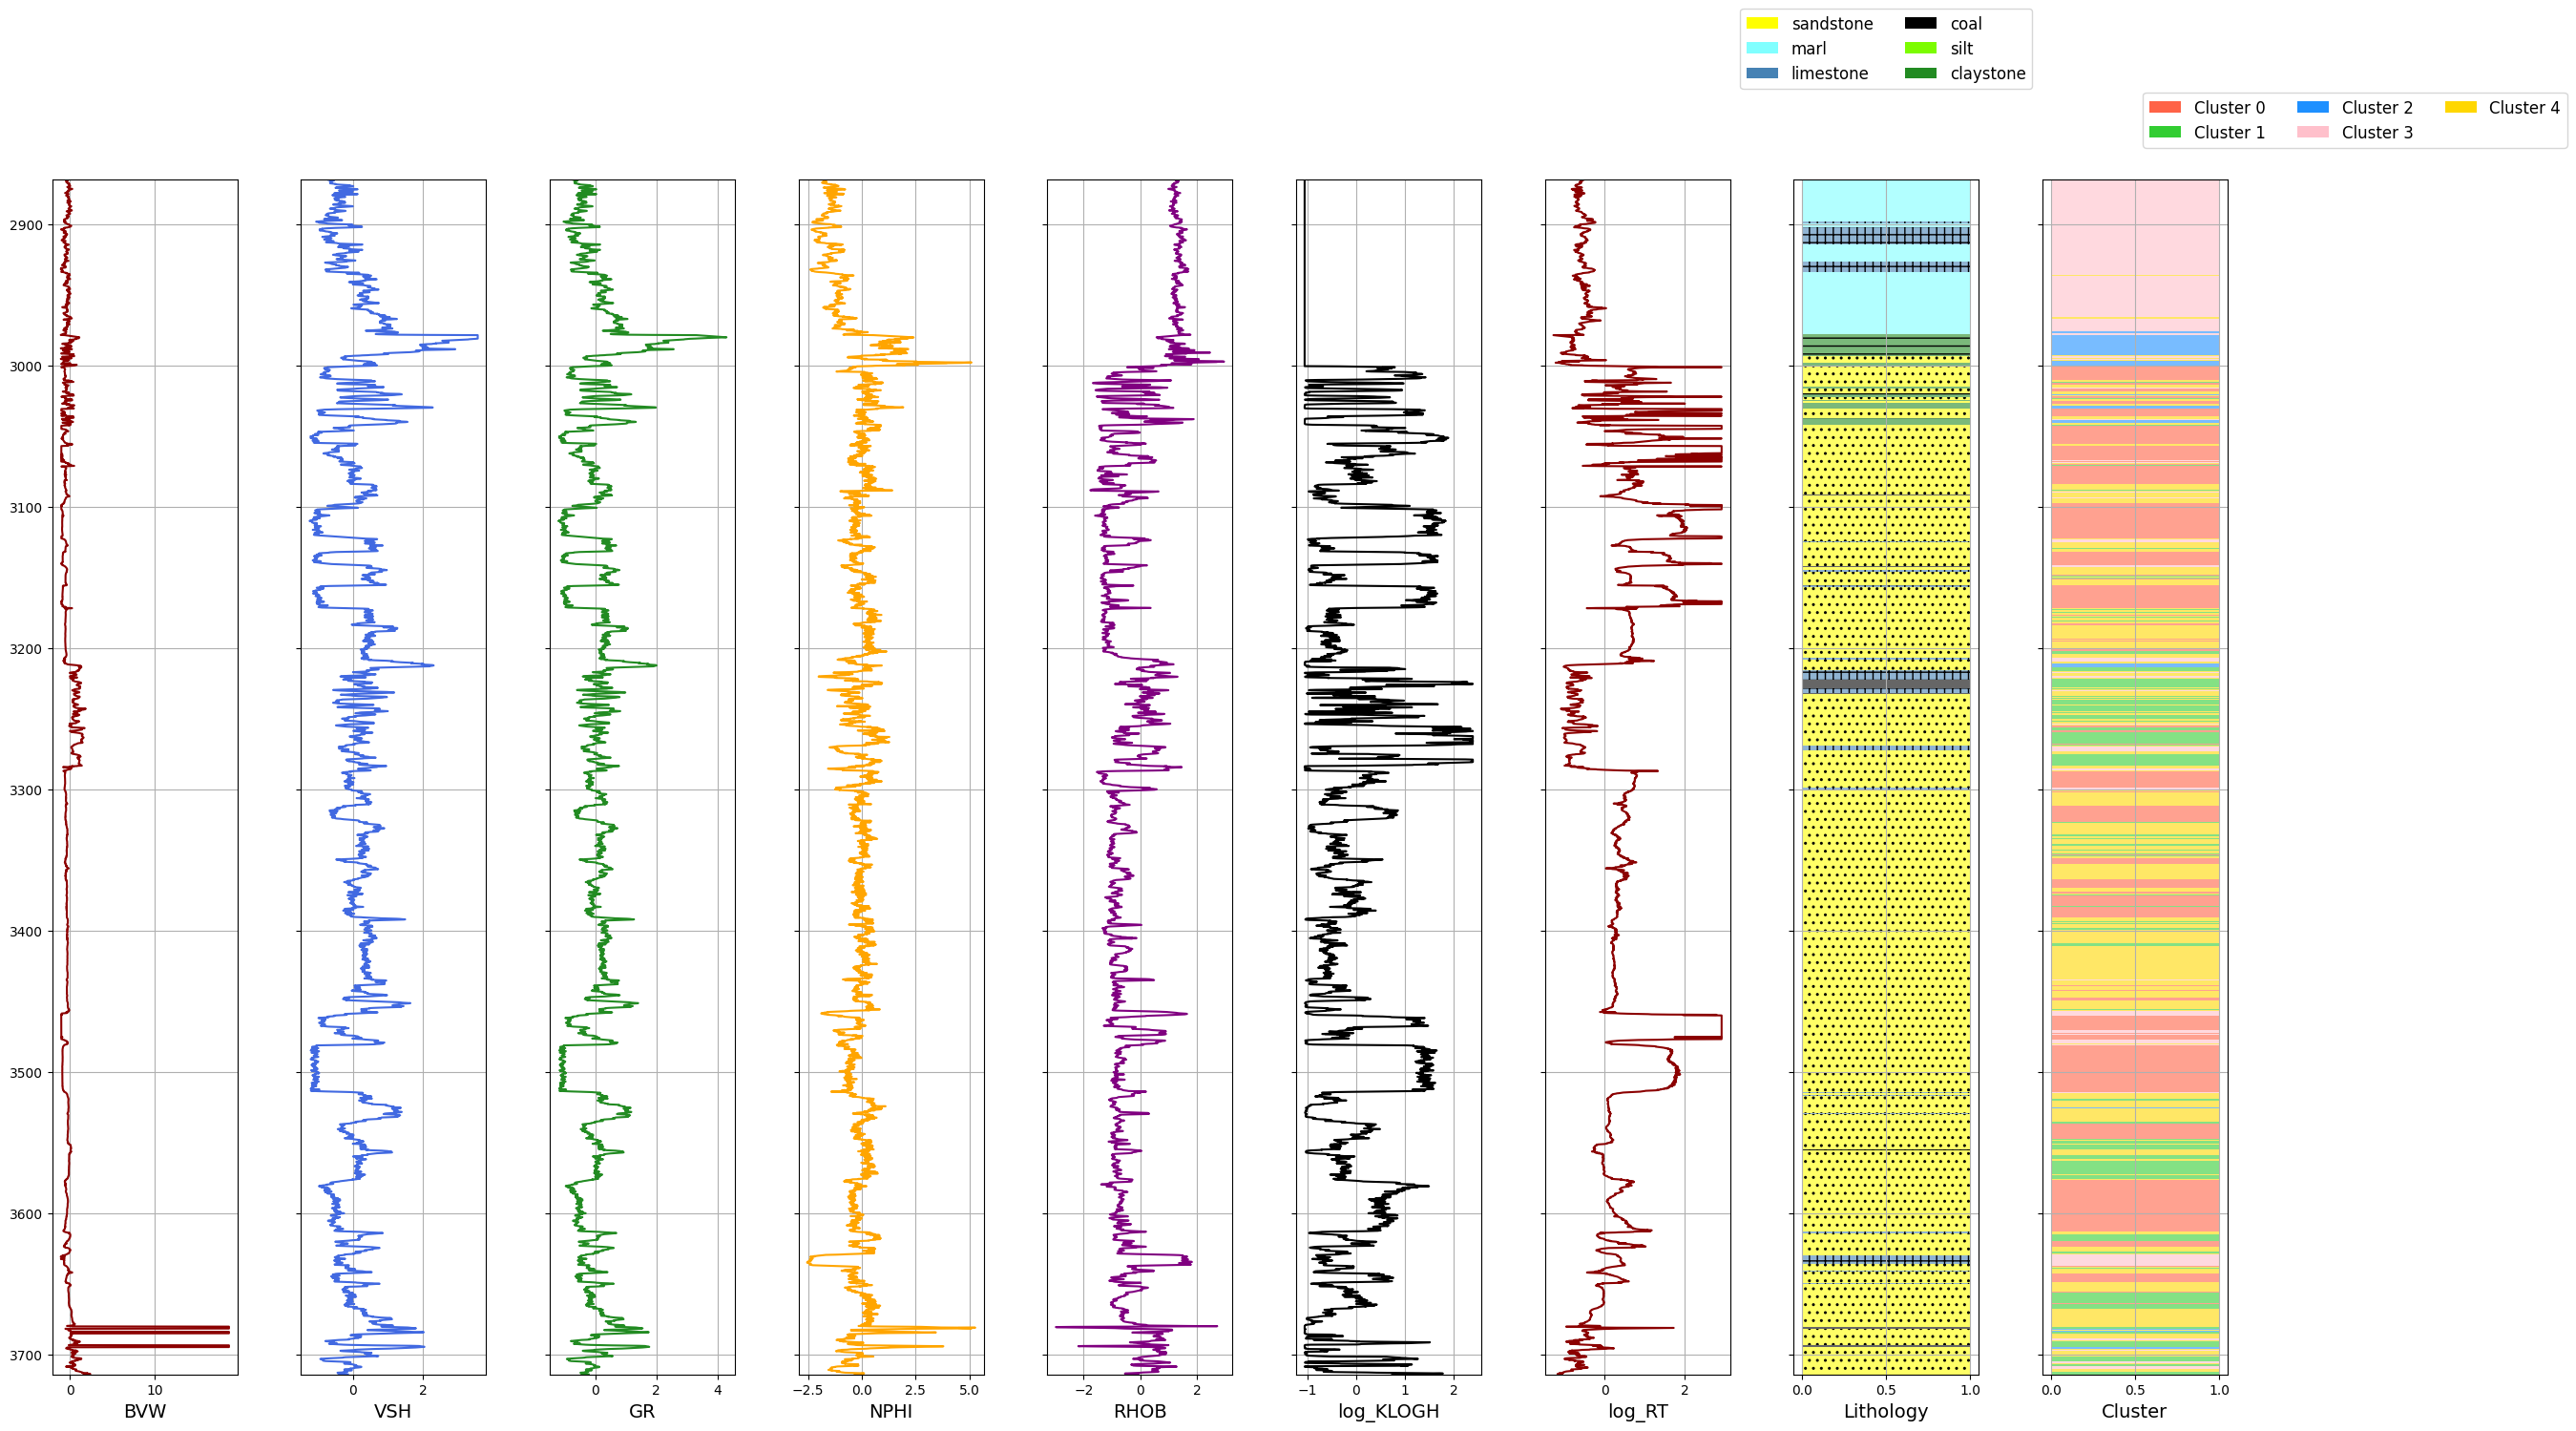

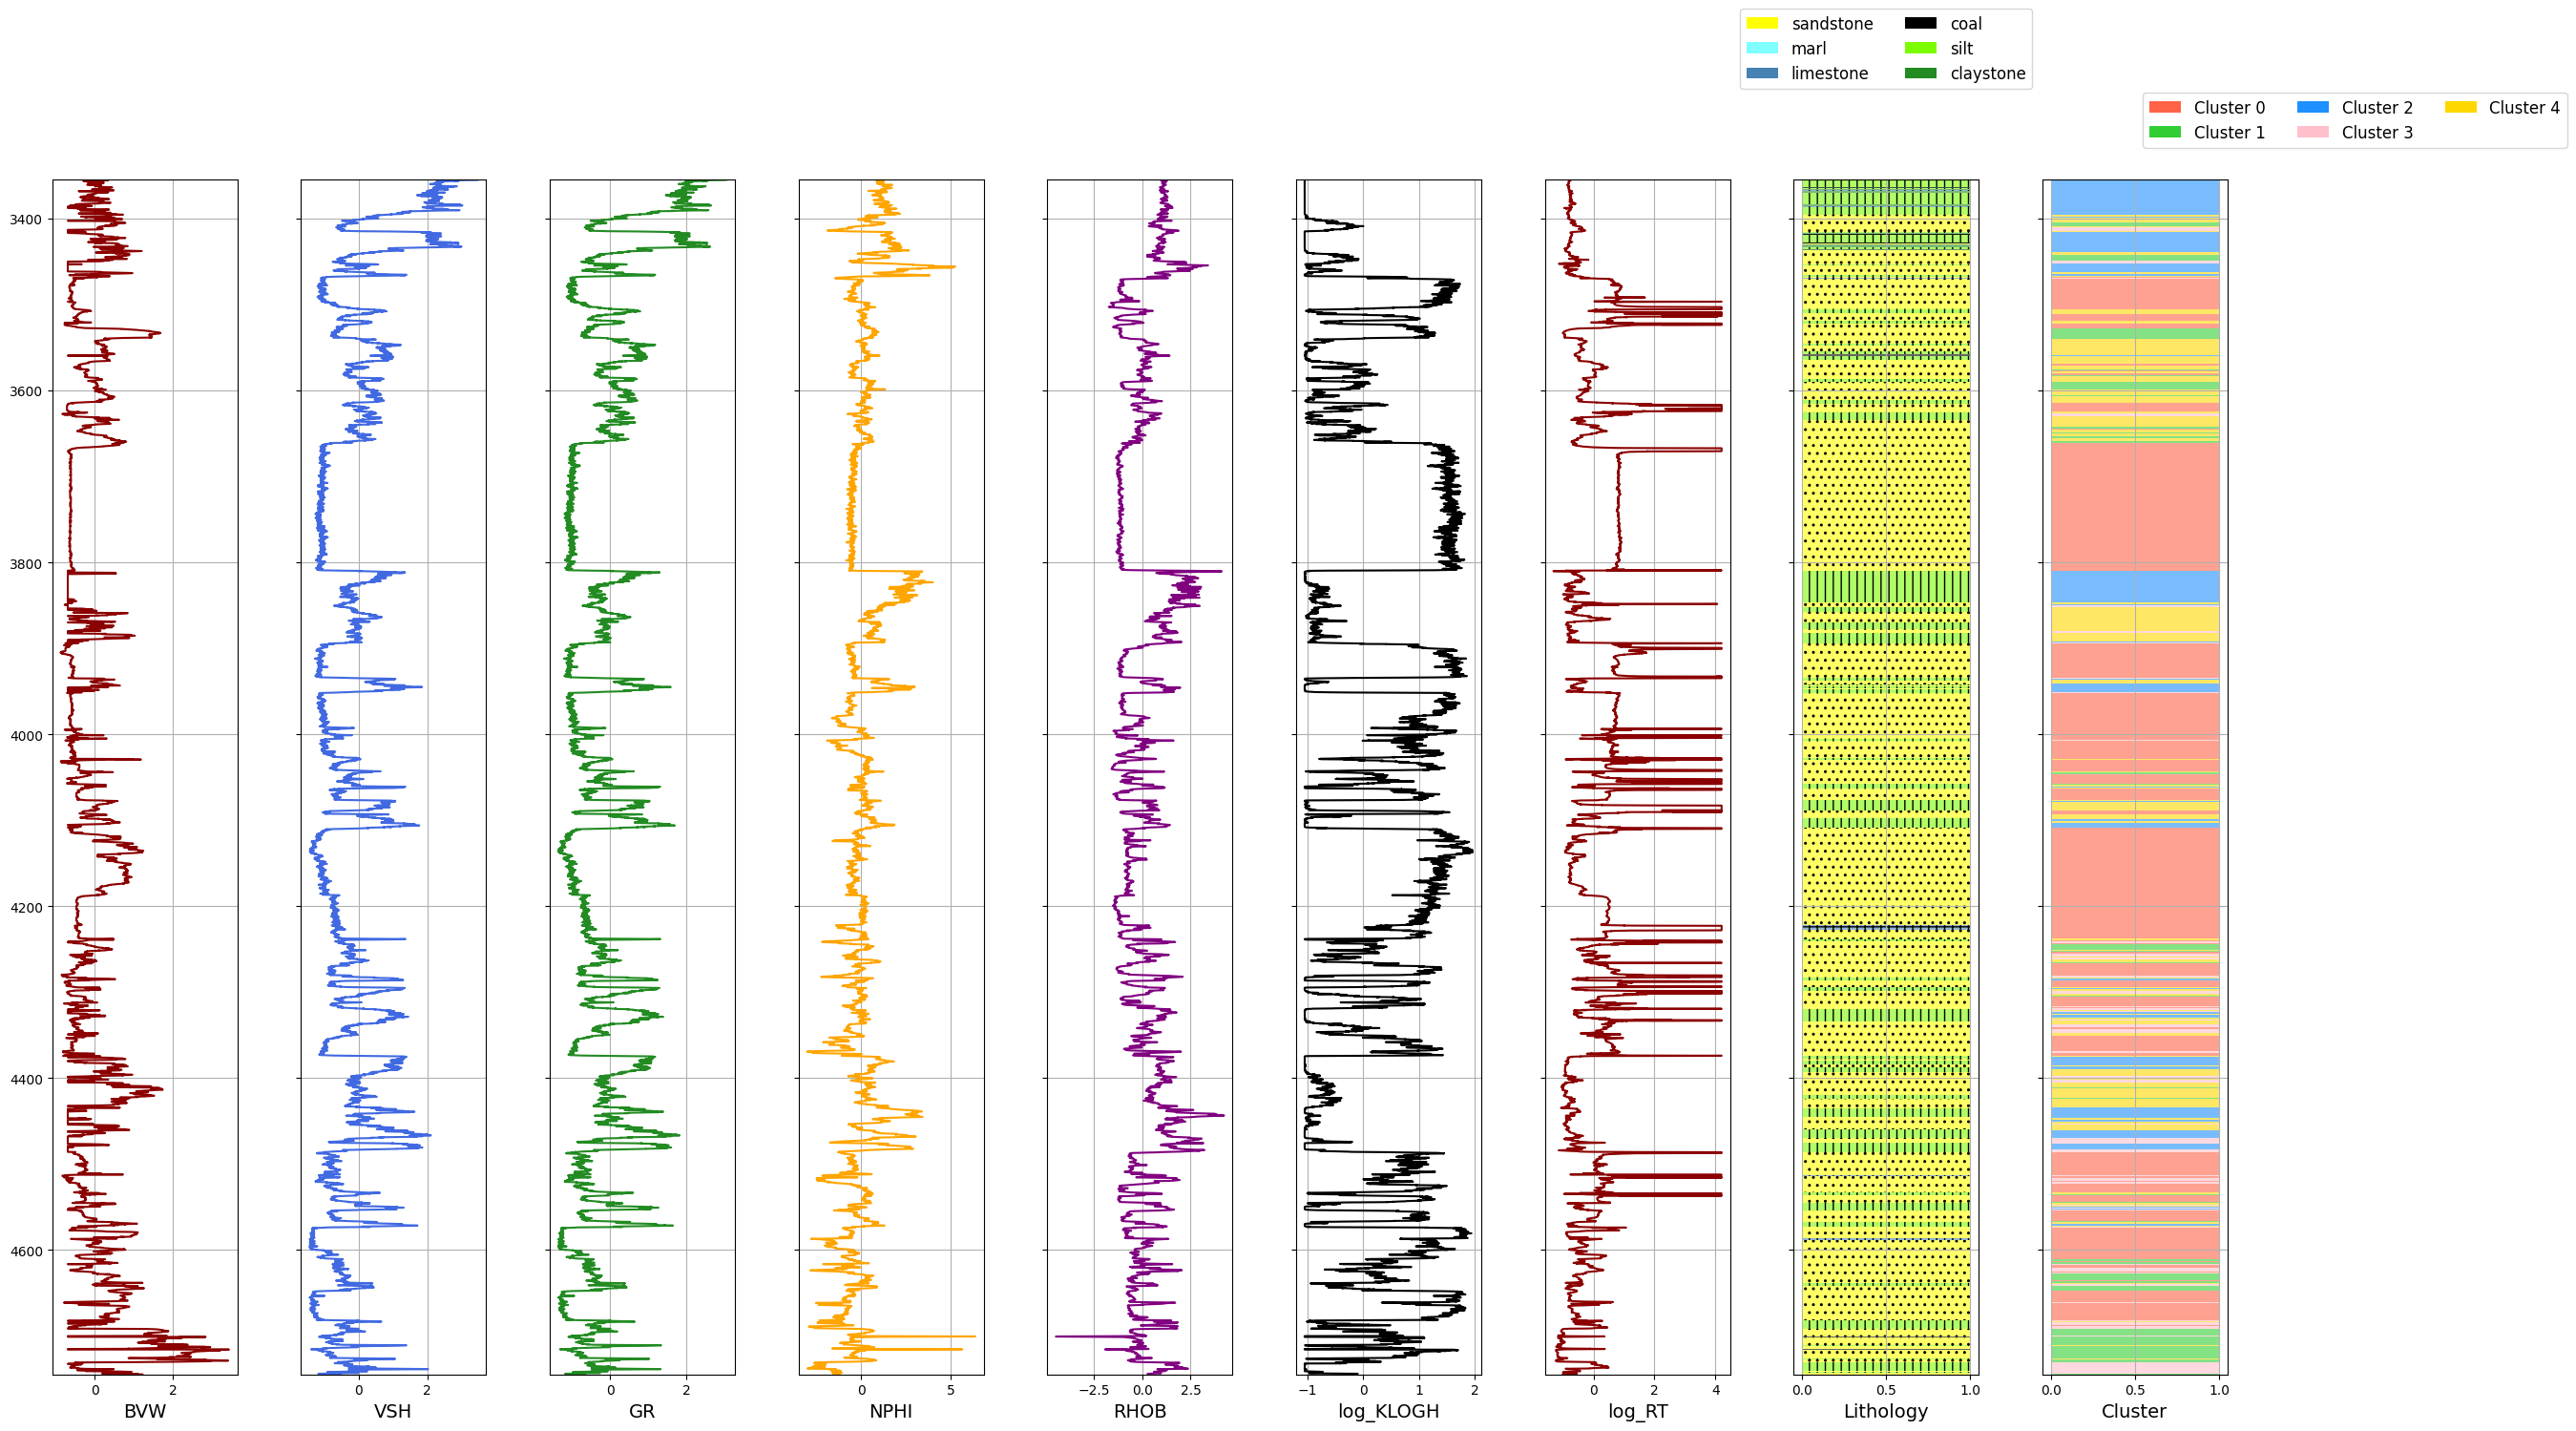

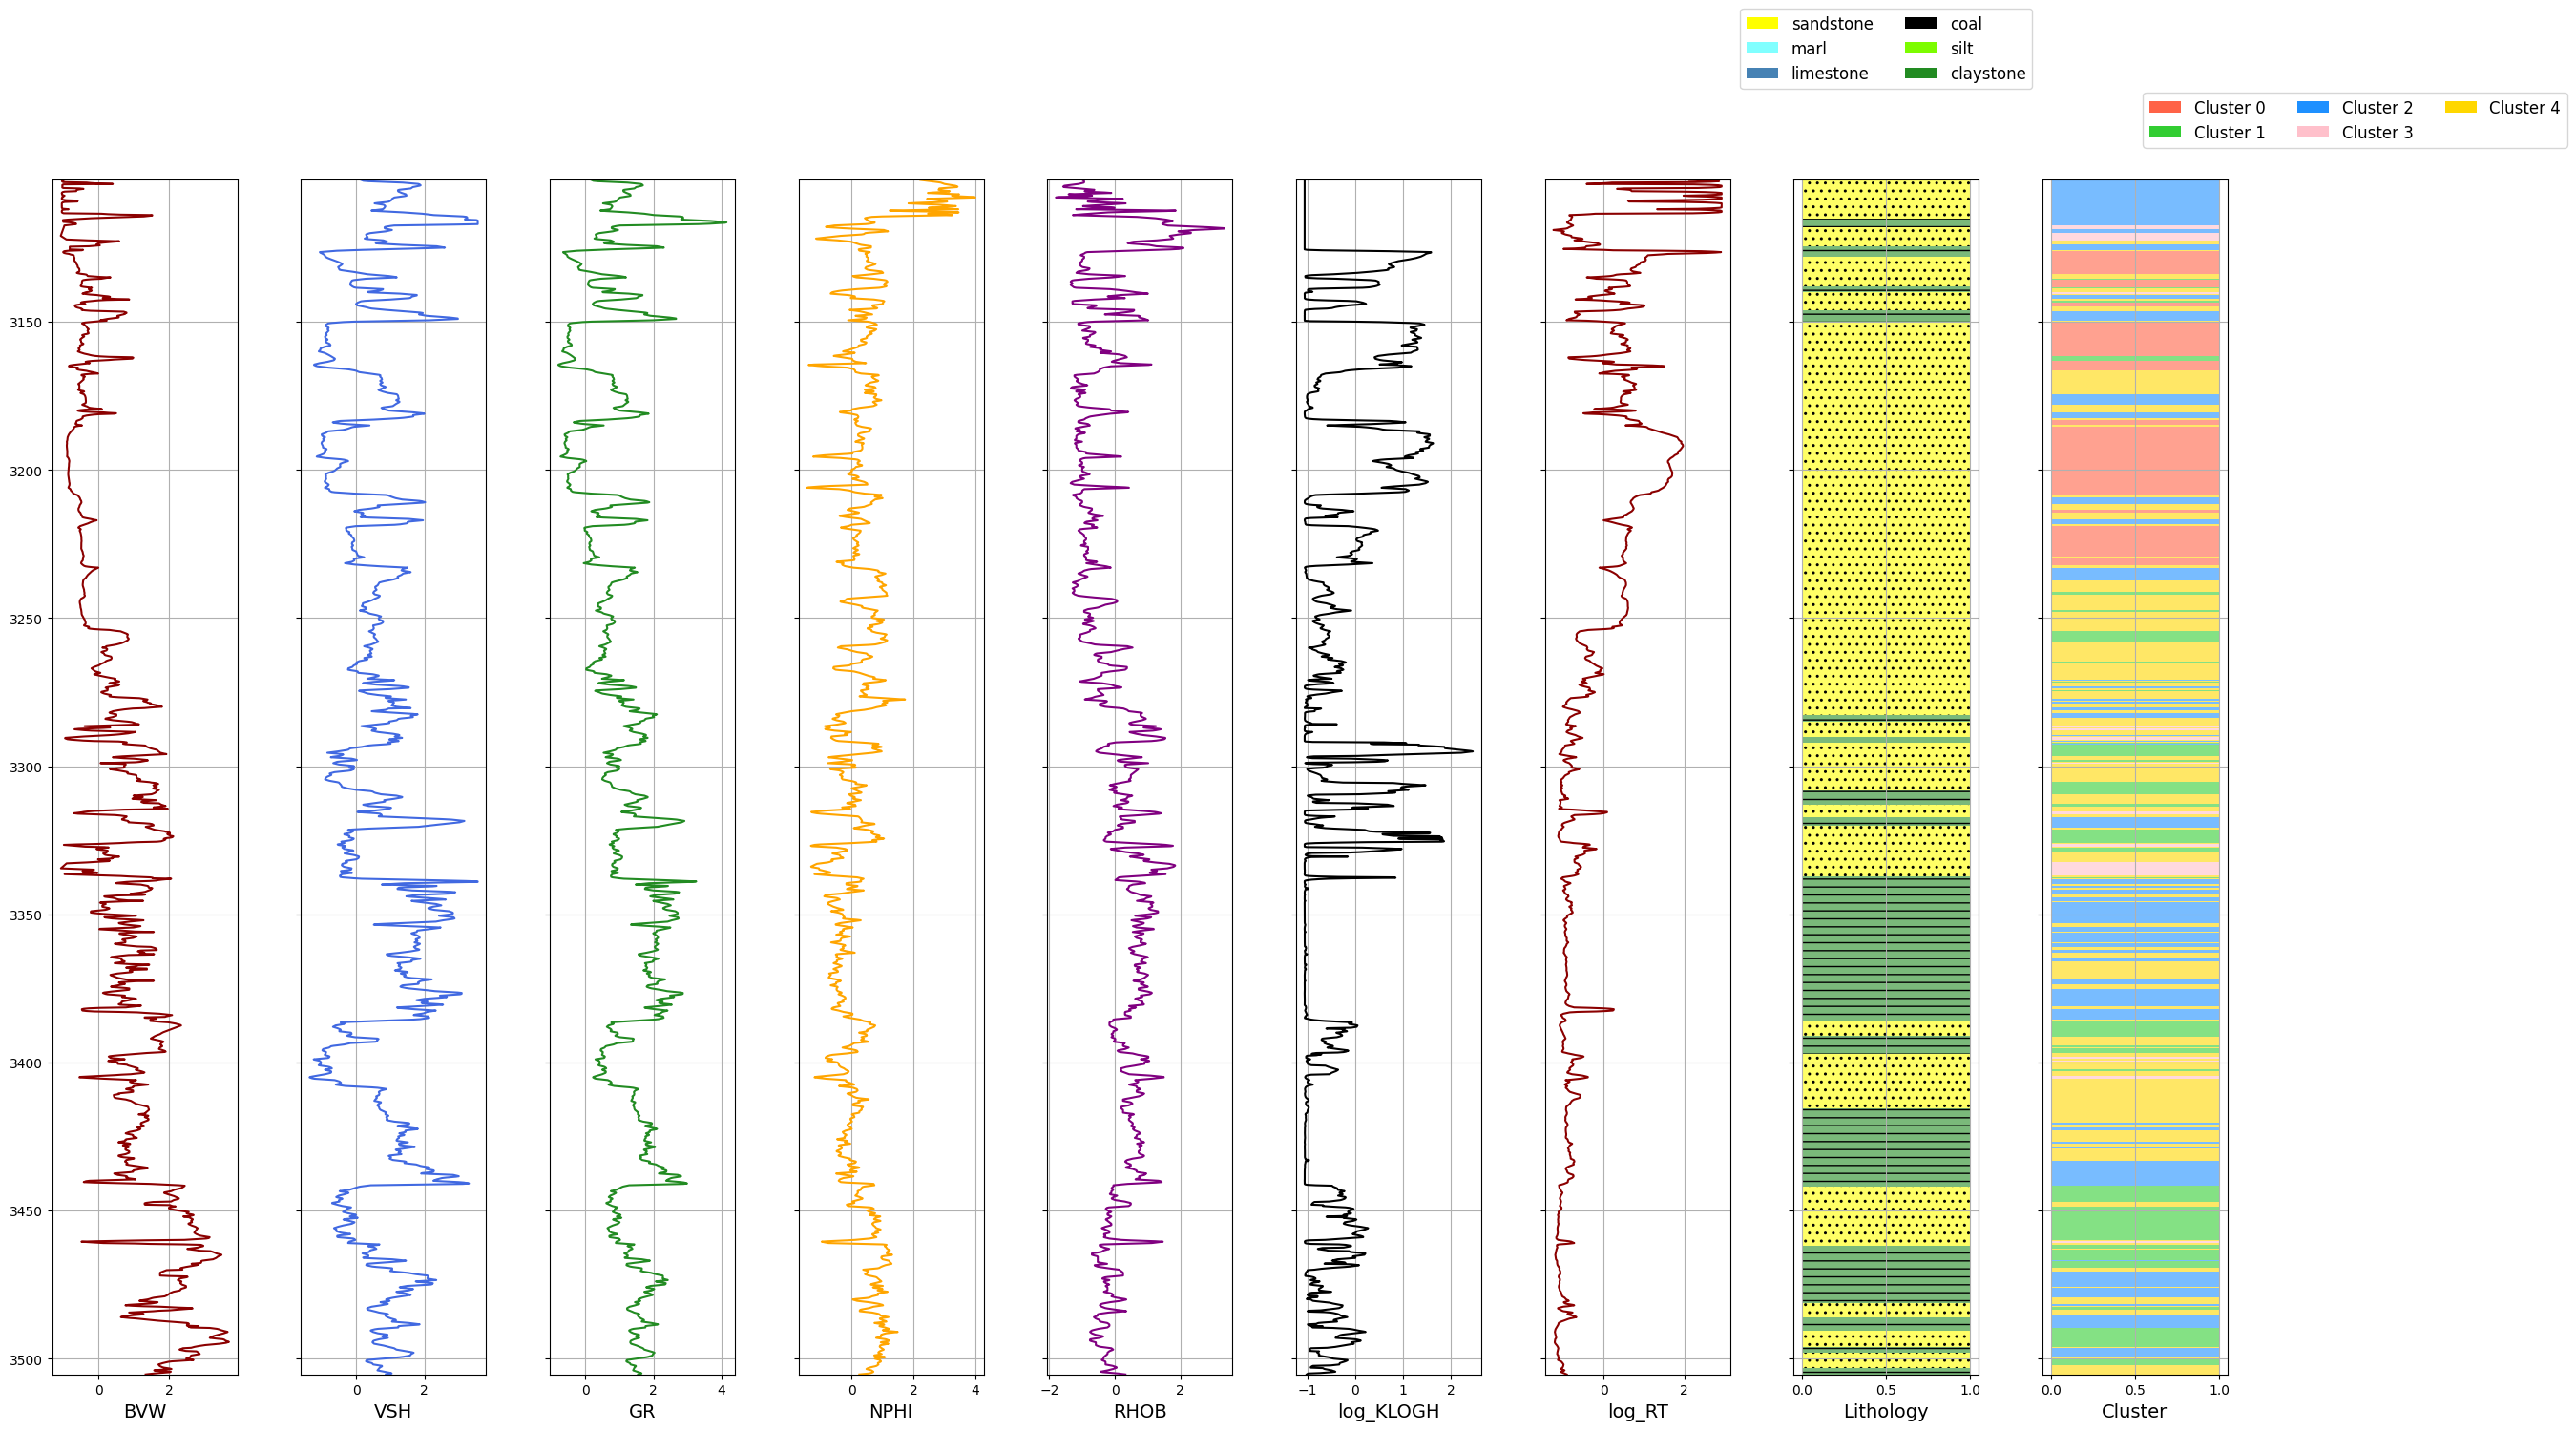

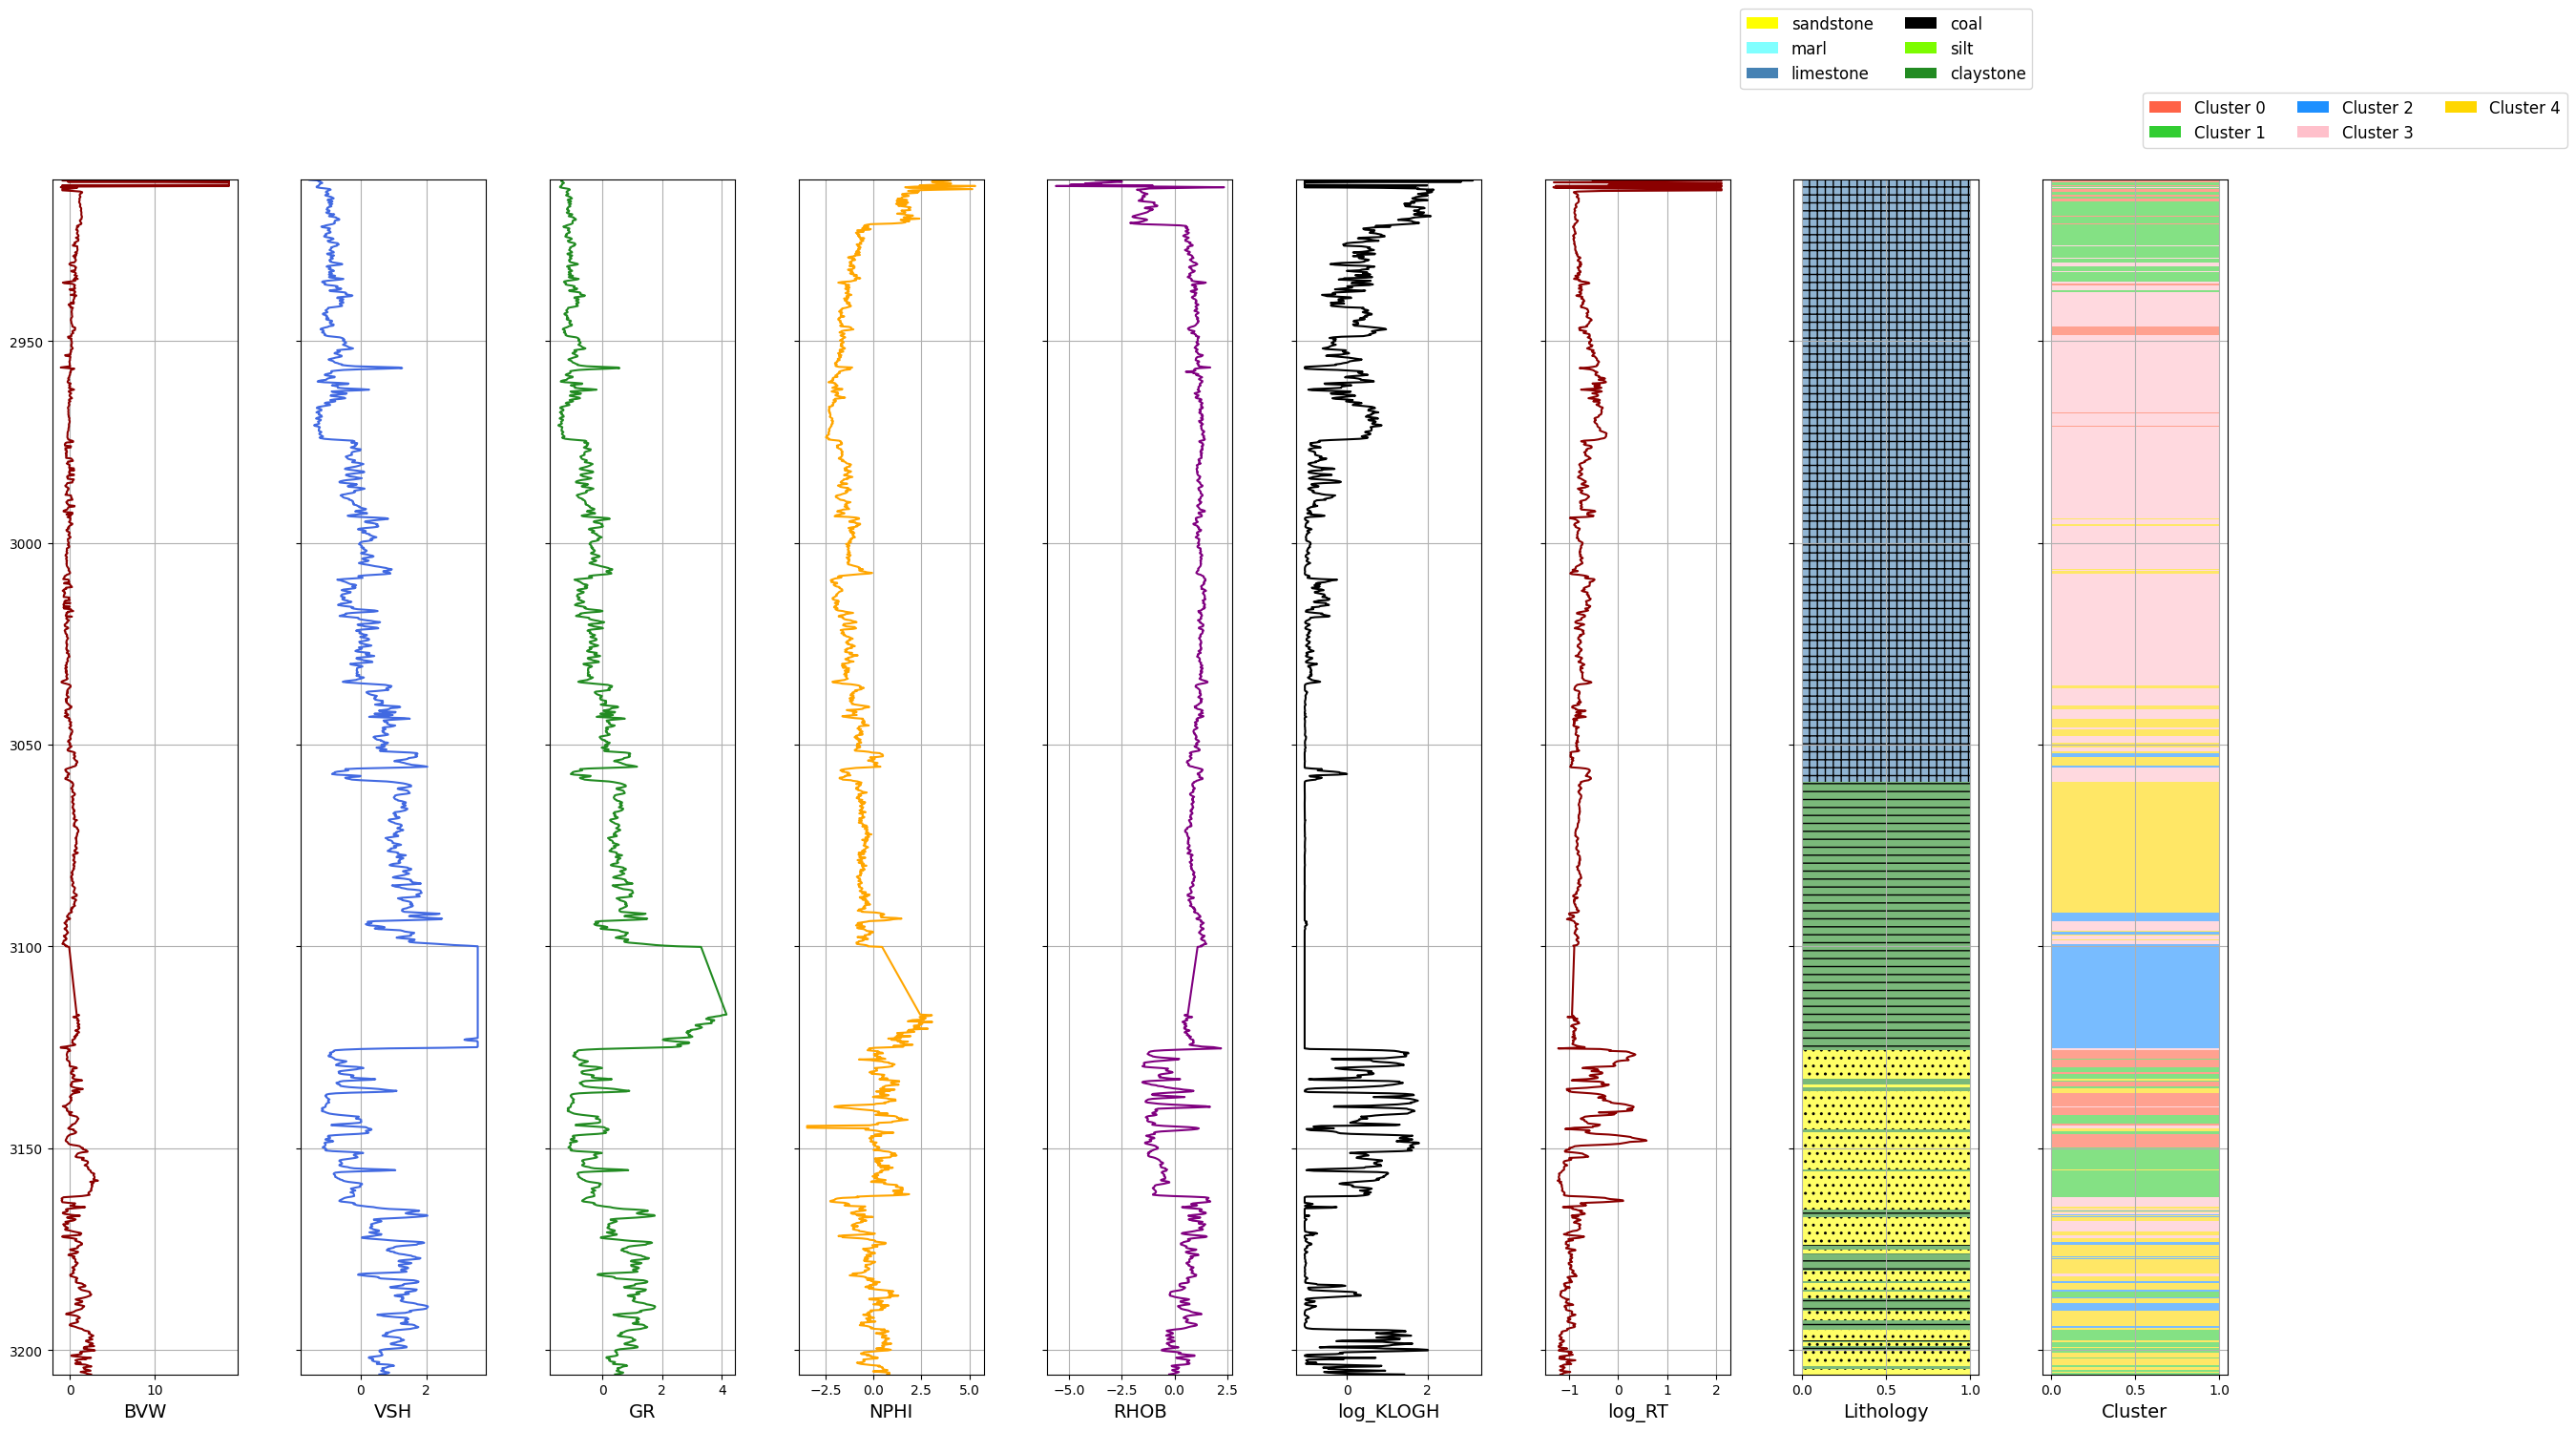

In [30]:
train_clustered_list = [train_clustered_1, train_clustered_2, train_clustered_3, train_clustered_4, train_clustered_5]

for train_clusters in train_clustered_list:
  KMeans_Clustering.visualise_lithology_clusters(train_clusters, log_columns=column_names)


Next, we use the trained KMeans model to predict the clusters for the first well in our test dataset. This step involves applying the model we trained earlier to a new, unseen dataset, allowing us to evaluate how well the clustering generalises to other wells.

In [31]:
standardised_test_well_data

[            DEPTH       BVW       VSH        GR      NPHI      RHOB  \
 0     3101.193802  1.147223  2.140465  2.993650  1.044434  0.570251   
 1     3101.346203  1.830479  2.142003  3.887993  1.818872  0.231619   
 22    3104.546609  1.911914  2.170207  4.345560  4.743919 -0.641946   
 205   3132.435865  1.280299  2.416865  4.349270  1.998847  0.376917   
 206   3132.588265  1.194892  2.417890  4.245780  1.989757  0.342520   
 ...           ...       ...       ...       ...       ...       ...   
 2580  3494.386589  0.920795  0.146180  0.531268 -1.031641  0.709025   
 2581  3494.538989  0.855249  0.119002  0.497639 -0.942562  0.733933   
 2582  3494.691389  0.843332  0.075926  0.444552 -1.146170  0.889906   
 2583  3494.843790  0.291166  0.090798  0.462541 -1.017097  0.898208   
 2584  3494.996190  0.235552  0.110284  0.486934 -1.080725  0.927268   
 
       LITHOLOGY  log_KLOGH    log_RT  
 0     Claystone  -1.052755 -0.927434  
 1     Claystone  -1.052755 -1.008915  
 22    Claysto

In [32]:
test_clustered_1 = KMeans_Clustering.run_kmeans_test(standardised_test_well_data[0], kmeans_model)
test_clustered_2 = KMeans_Clustering.run_kmeans_test(standardised_test_well_data[1], kmeans_model)

Now that we have assigned clusters to the first test well, we can visualise the results. We’ll plot the clusters on a graph to see how well KMeans has identified the different lithologies in the well. This will create a visual representation of the clusters, making it easier to interpret the results and see how the KMeans algorithm has grouped the data.

In [33]:
column_names = standardised_test_well_data[0].columns.tolist()
column_names = [col for col in column_names if col != "DEPTH"]
column_names = [col for col in column_names if col != "LITHOLOGY"]

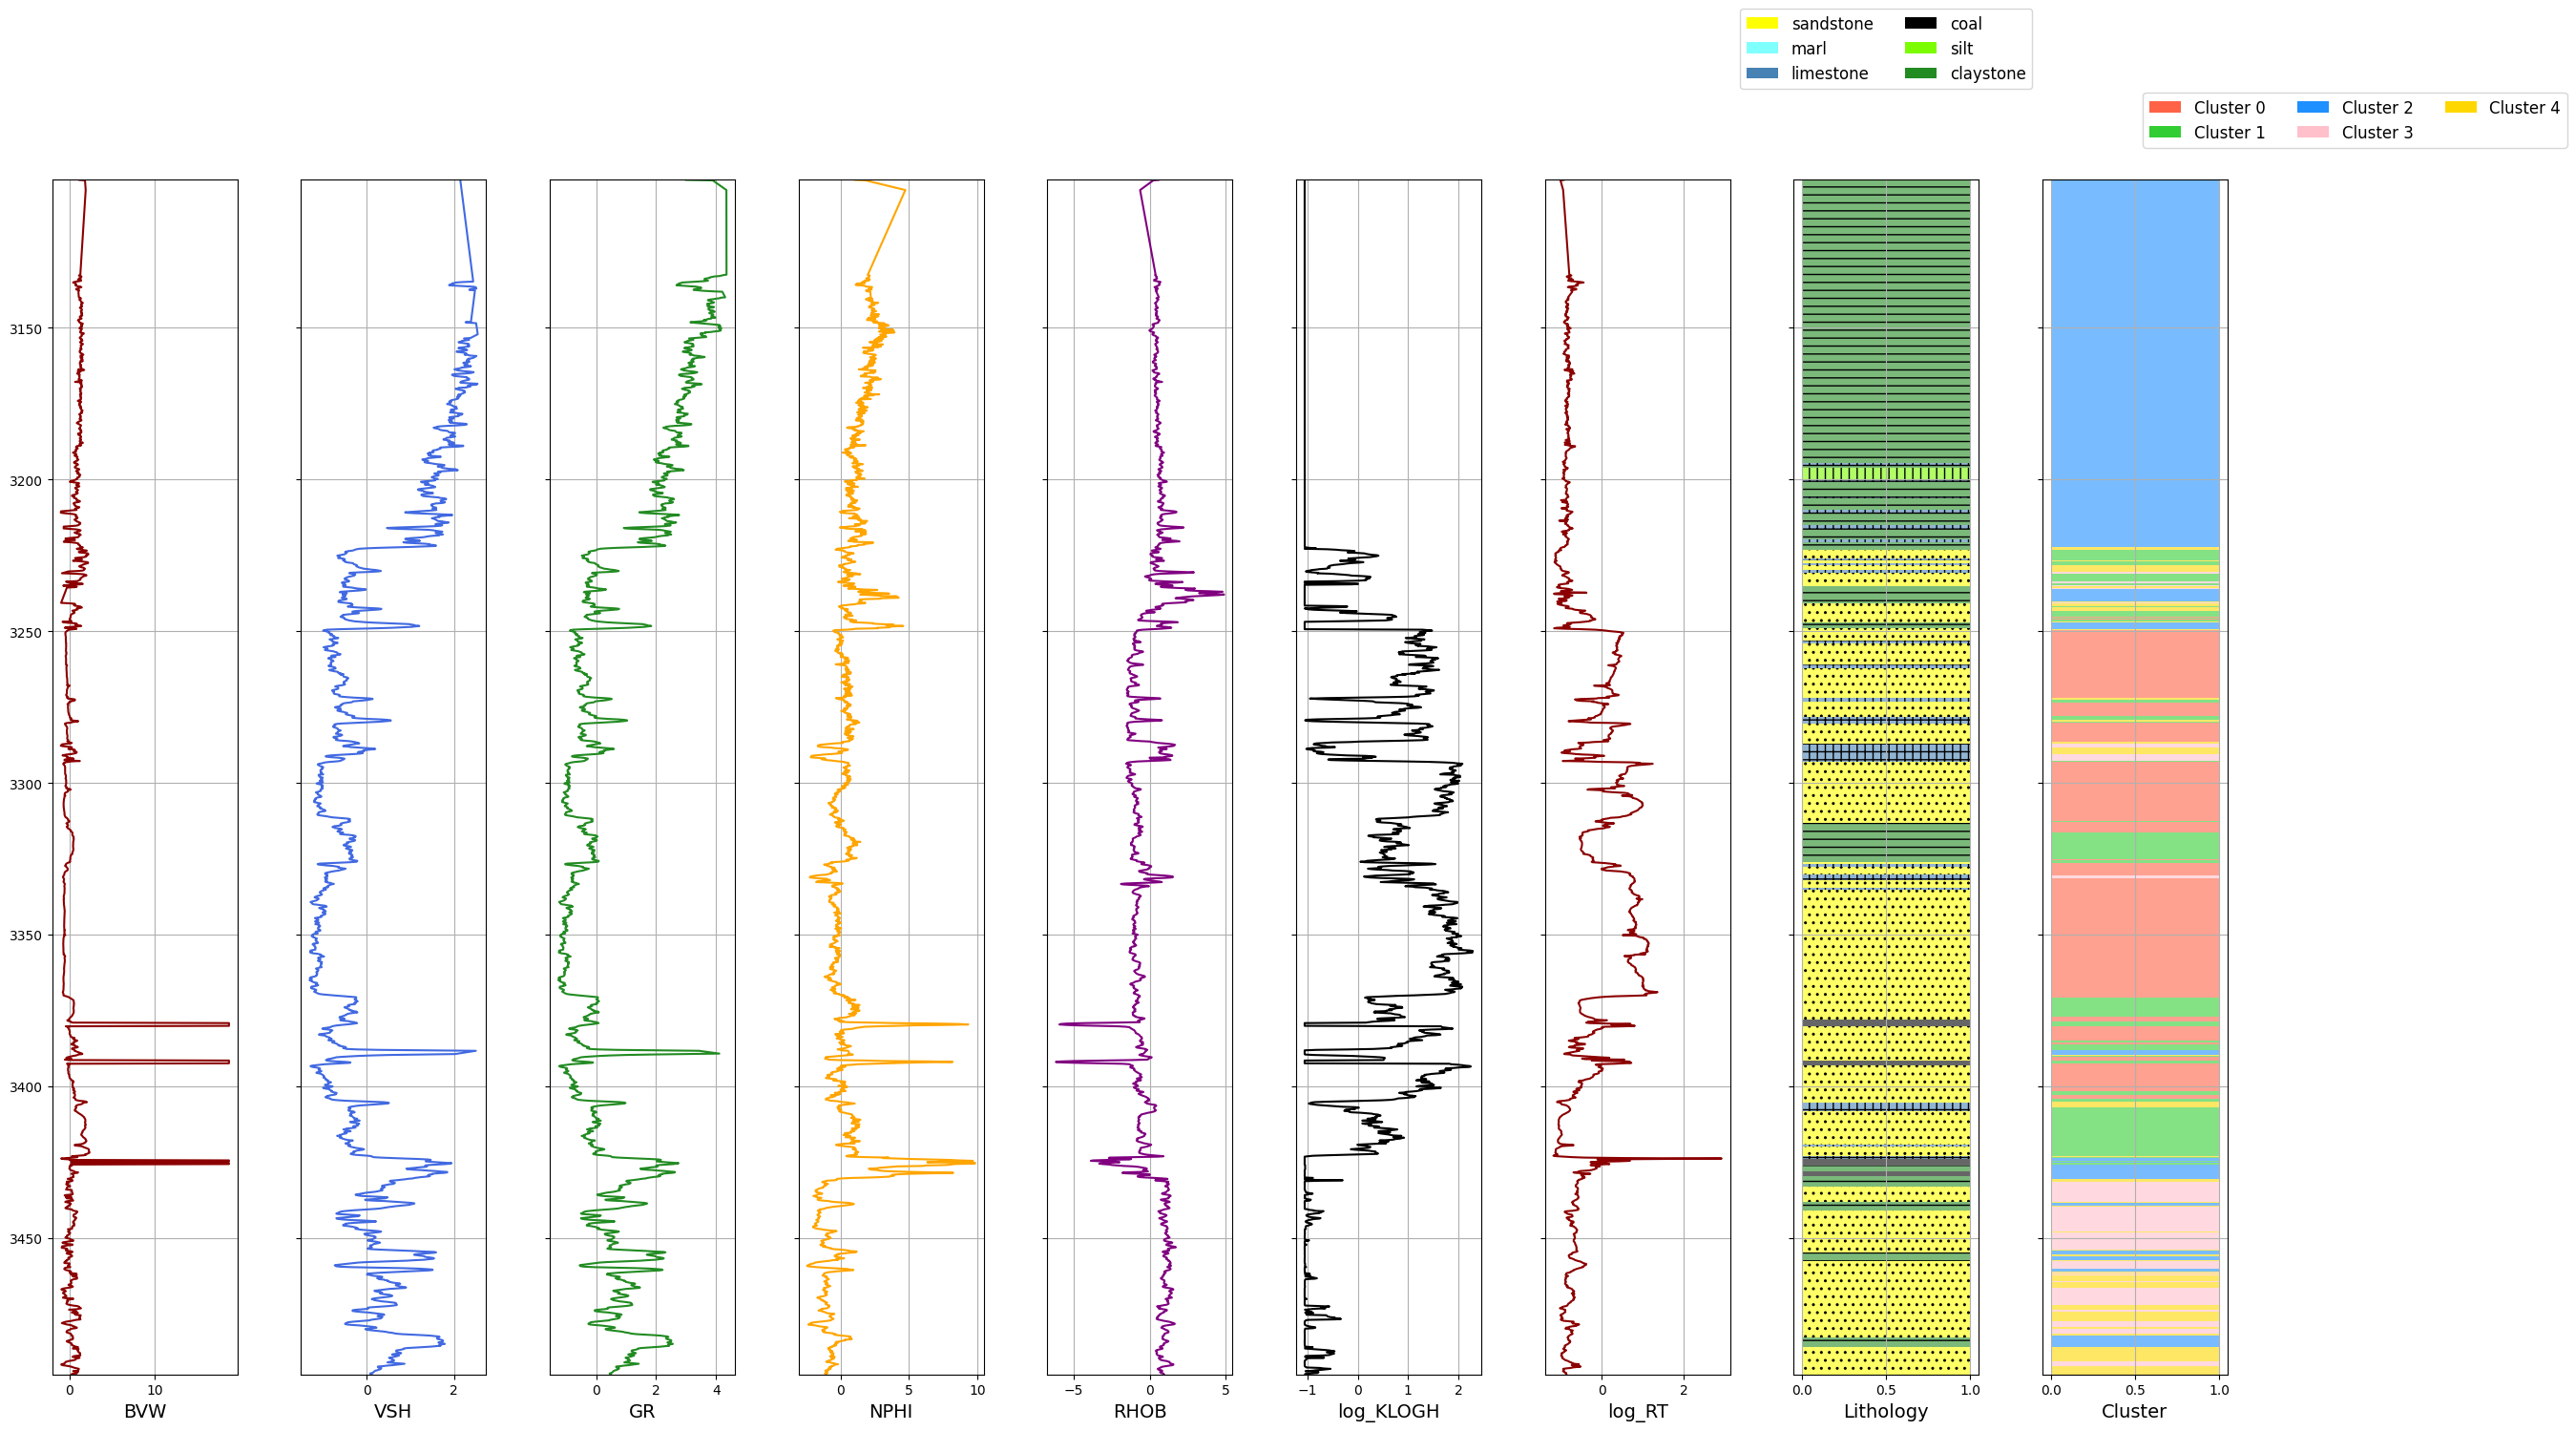

In [34]:
KMeans_Clustering.visualise_lithology_clusters(test_clustered_1, log_columns=column_names)

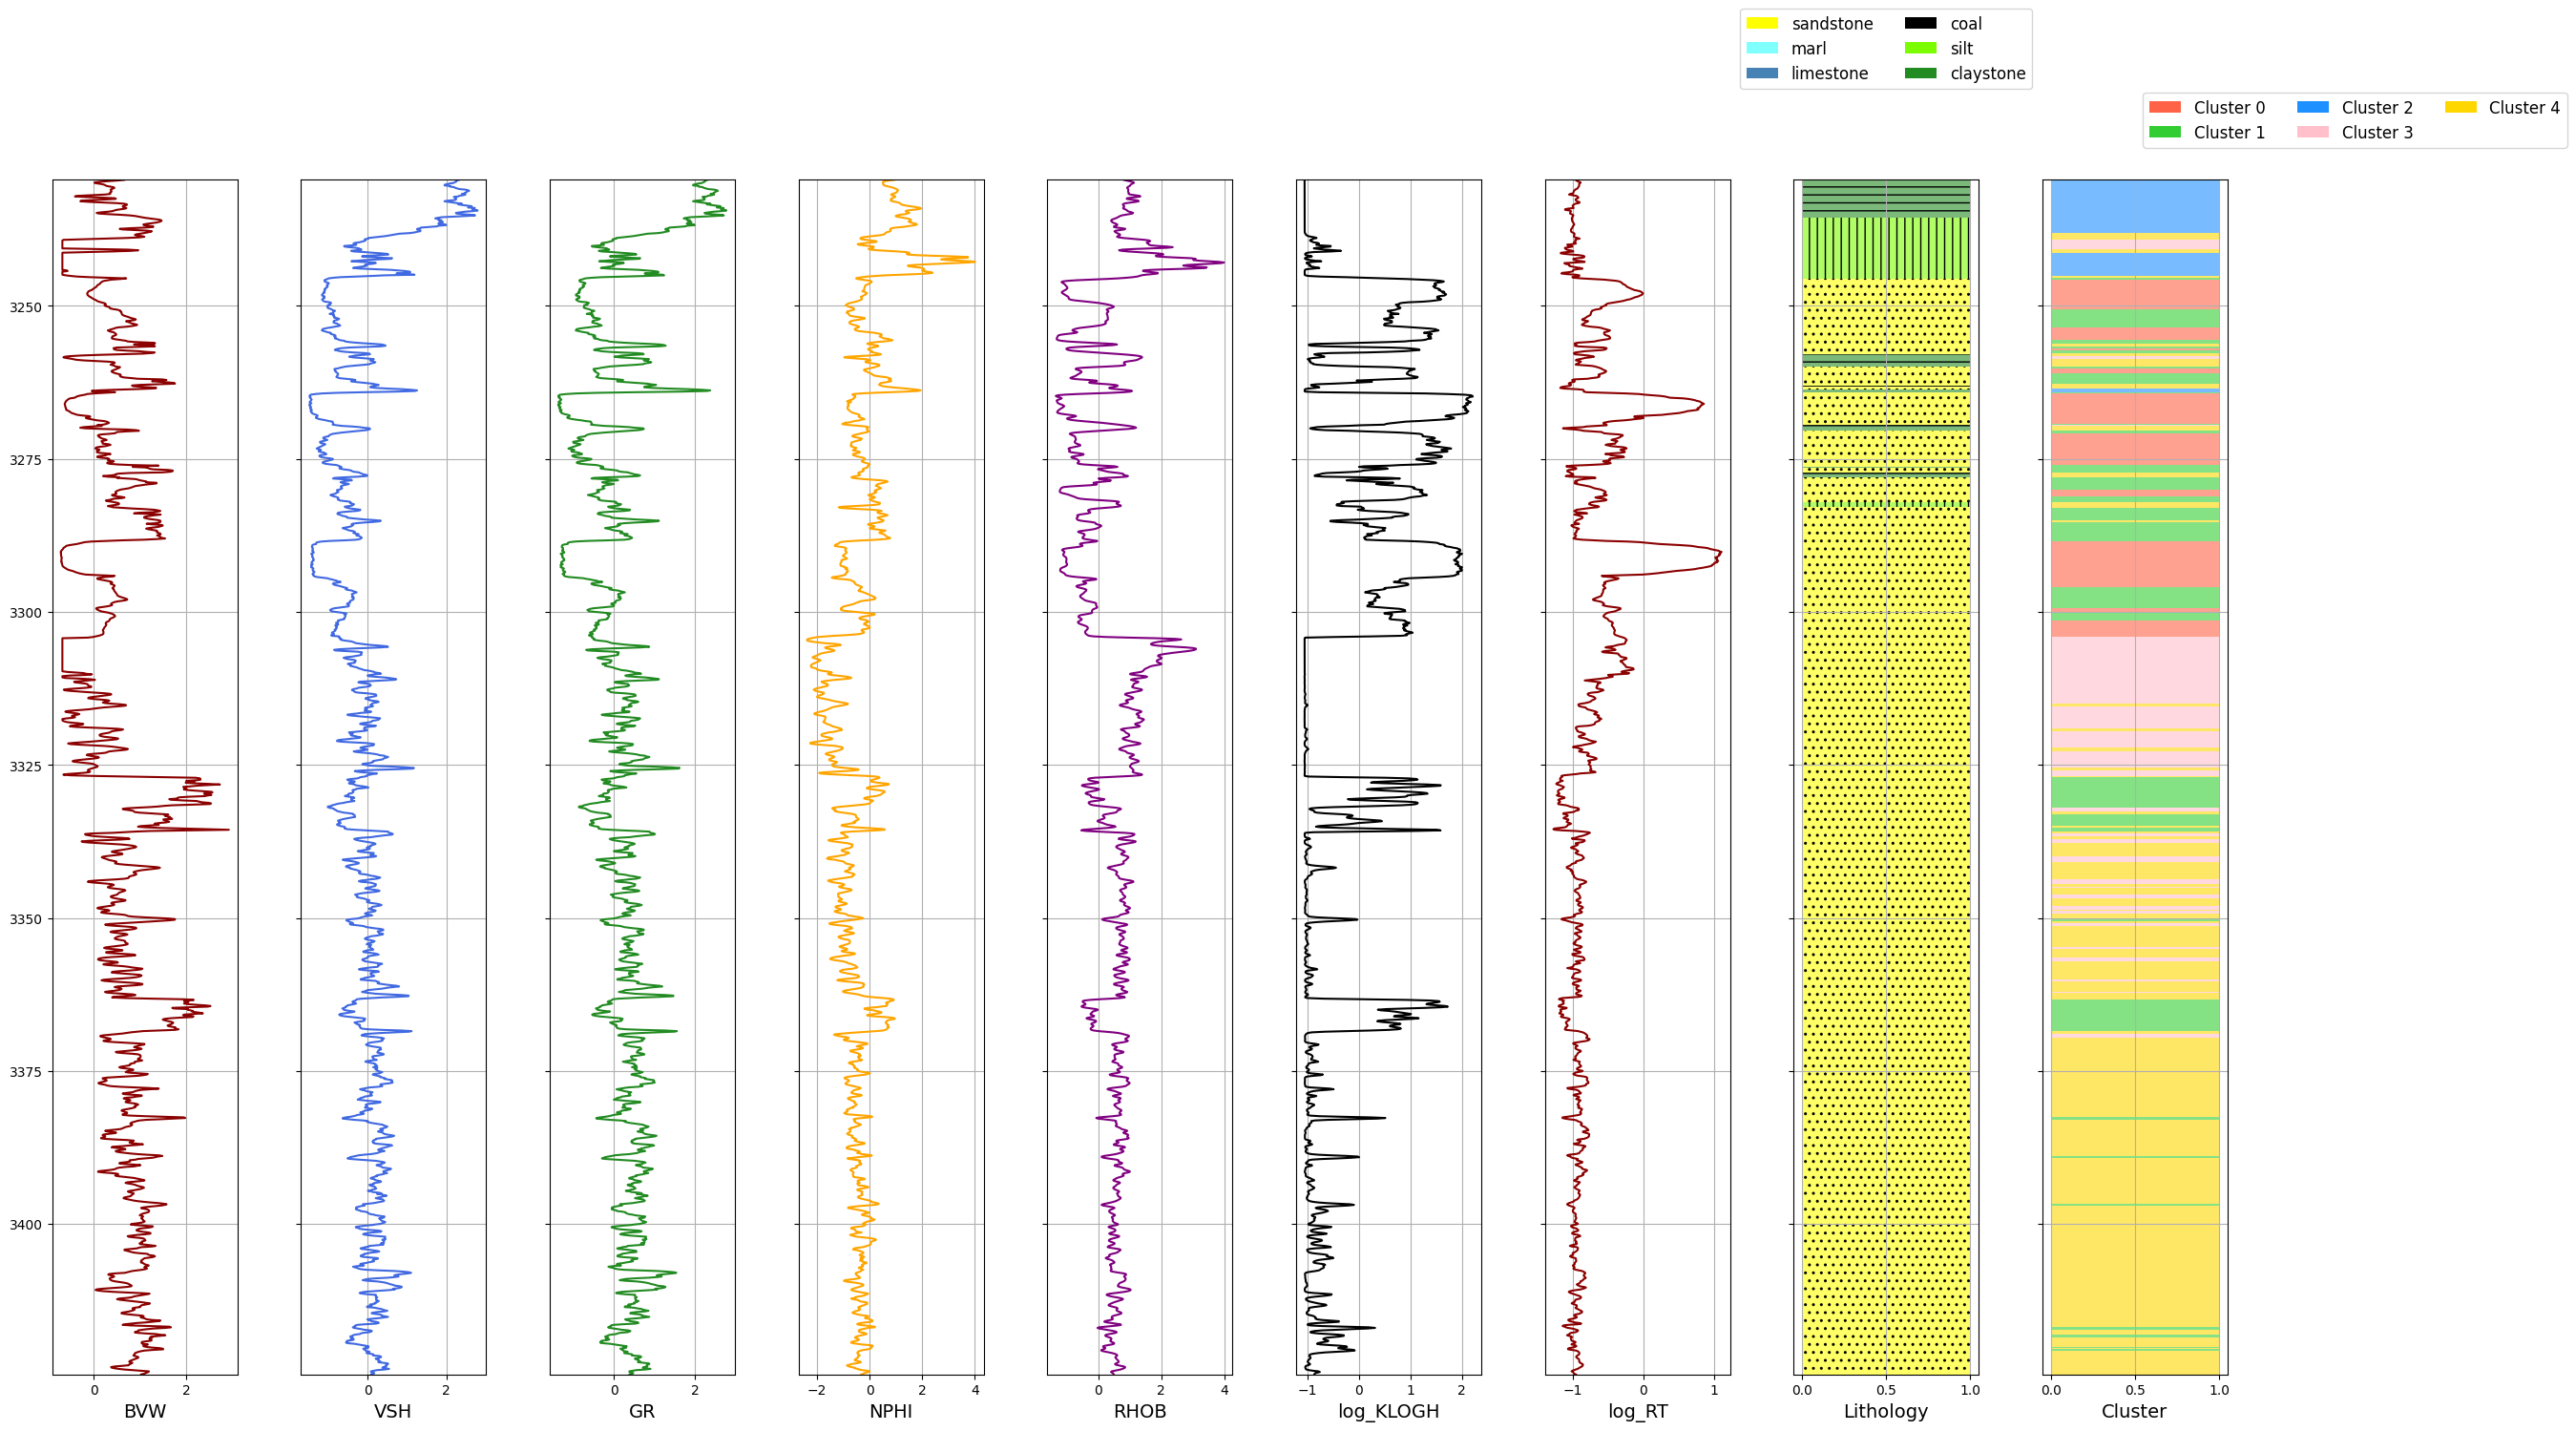

In [35]:
KMeans_Clustering.visualise_lithology_clusters(test_clustered_2, log_columns=column_names)

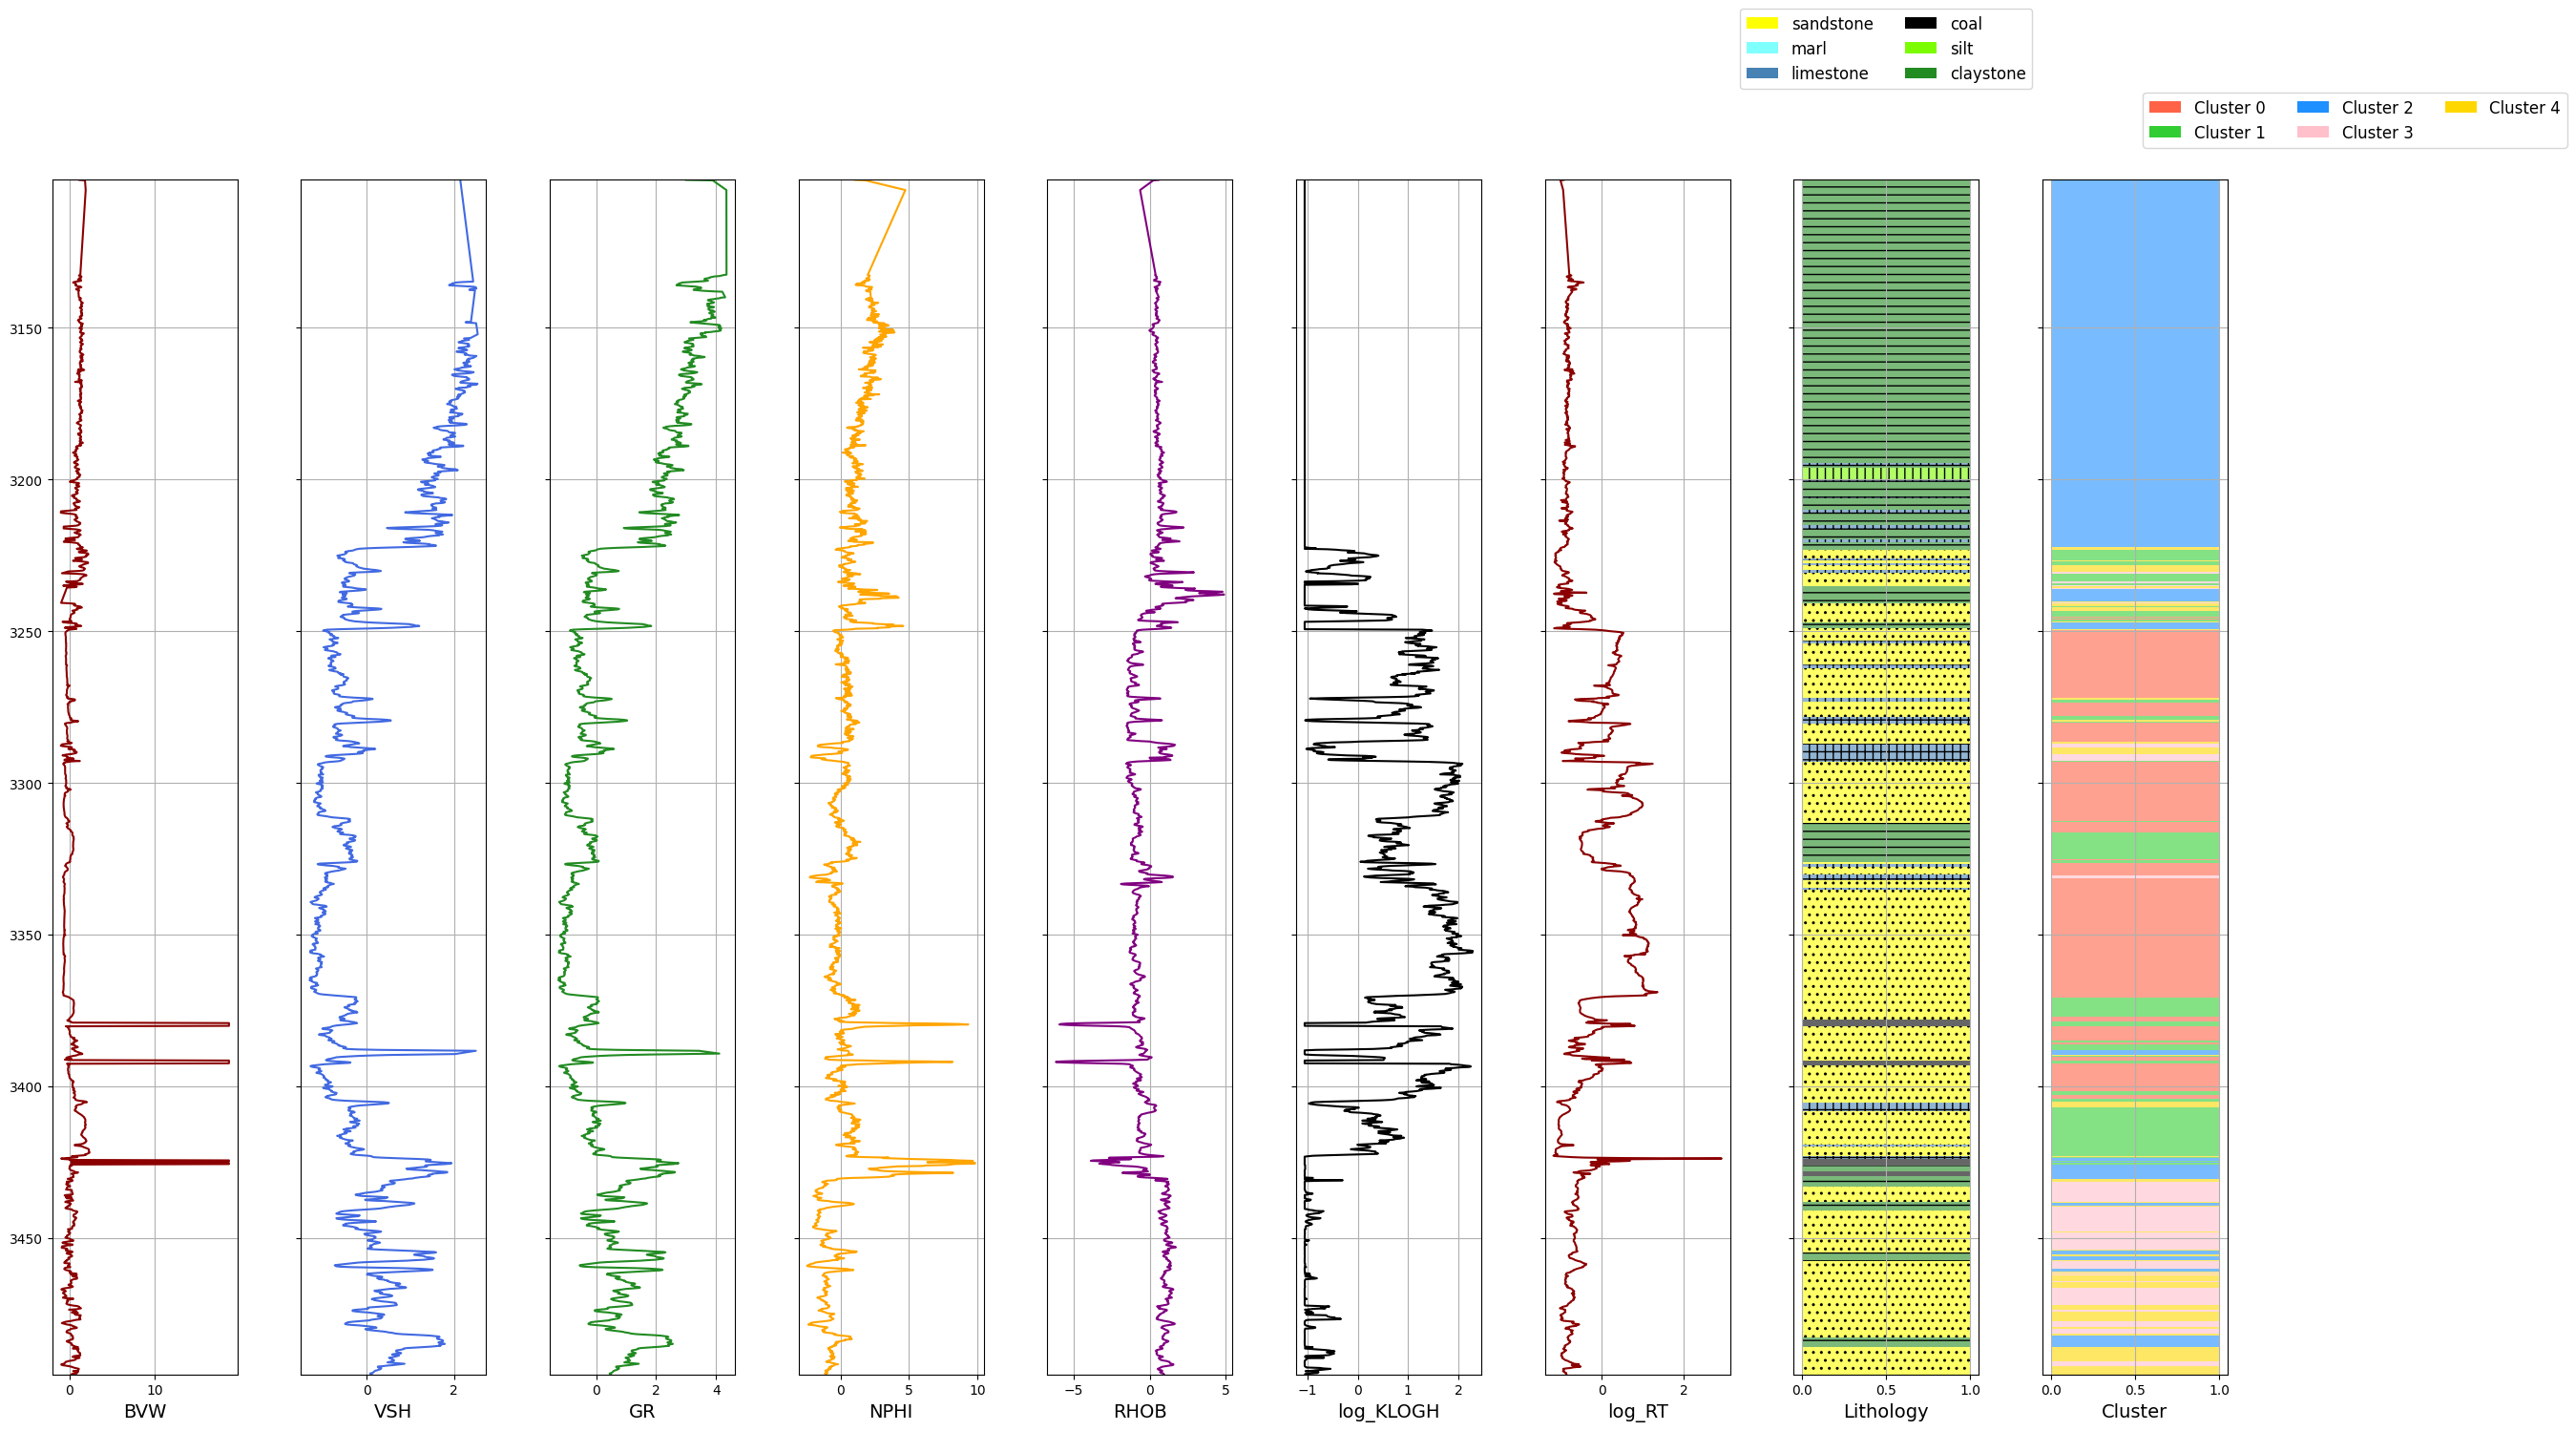

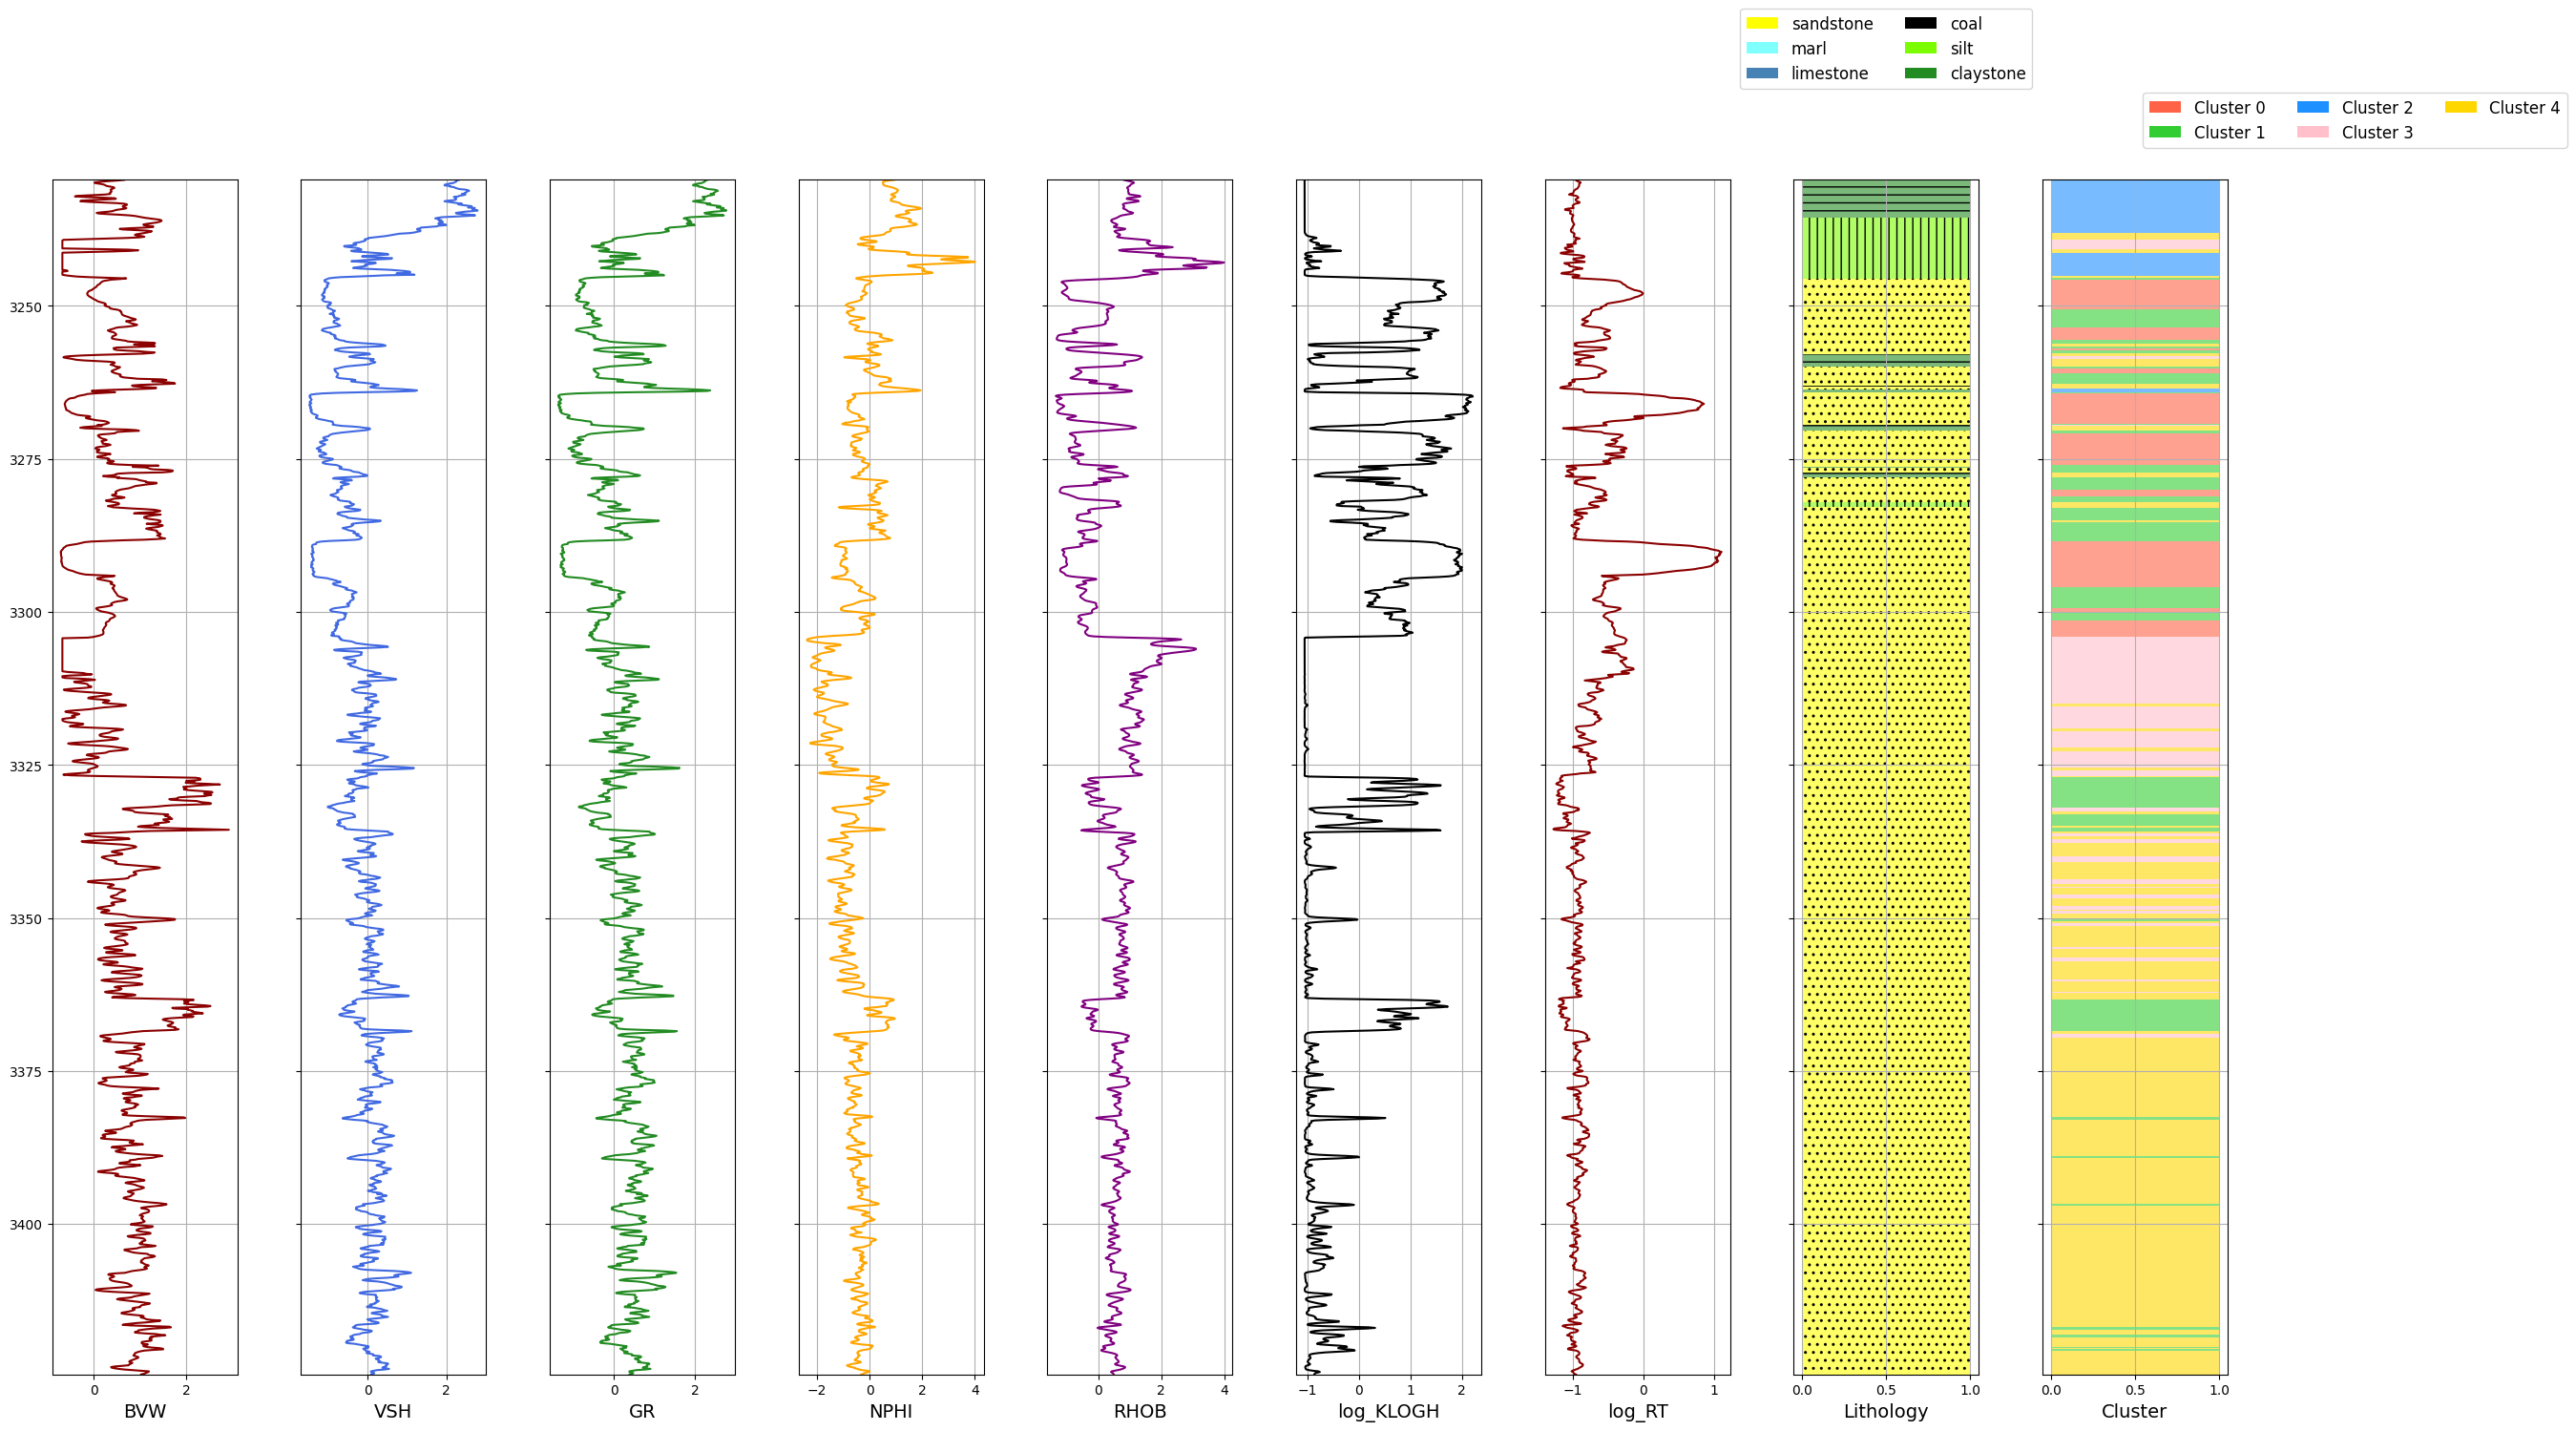

In [36]:
test_clustered_list = [test_clustered_1, test_clustered_2]

for test_clusters in test_clustered_list:
  KMeans_Clustering.visualise_lithology_clusters(test_clusters, log_columns = column_names)

And finally, we can save the model for later use.

In [37]:
from joblib import dump
from google.colab import drive

# Save the model to a file
dump(kmeans_model, 'kmeans_model.joblib')

# Save to Google Drive
drive.mount('/content/drive')
dump(kmeans_model, '/content/drive/MyDrive/kmeans_model.joblib')

Mounted at /content/drive


['/content/drive/MyDrive/kmeans_model.joblib']